In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import json

import sys

sys.path.append("../")

##################################################################
os.environ["TOKENIZERS_PARALLELISM"] = "false"
# os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3,4,5,6,7"
##################################################################

import logging
from src.utils import logging_utils
from src.utils import env_utils

logger = logging.getLogger(__name__)

logging.basicConfig(
    level=logging.DEBUG,
    format=logging_utils.DEFAULT_FORMAT,
    datefmt=logging_utils.DEFAULT_DATEFMT,
    stream=sys.stdout,
)

import torch
import transformers

logger.info(f"{torch.__version__=}, {torch.version.cuda=}")
logger.info(
    f"{torch.cuda.is_available()=}, {torch.cuda.device_count()=}, {torch.cuda.get_device_name()=}"
)
logger.info(f"{transformers.__version__=}")

2025-09-09 17:25:06 __main__ INFO     torch.__version__='2.7.0+cu126', torch.version.cuda='12.6'
2025-09-09 17:25:06 __main__ INFO     torch.cuda.is_available()=True, torch.cuda.device_count()=8, torch.cuda.get_device_name()='NVIDIA A100 80GB PCIe'
2025-09-09 17:25:06 __main__ INFO     transformers.__version__='4.55.3'


In [3]:
from src.utils.training_utils import get_device_map

# model_key = "meta-llama/Llama-3.2-3B"
# model_key = "meta-llama/Llama-3.1-8B"
# model_key = "meta-llama/Llama-3.1-70B-Instruct"
model_key = "meta-llama/Llama-3.3-70B-Instruct"
# model_key = "meta-llama/Llama-3.1-405B-Instruct"

# model_key = "google/gemma-2-9b-it"
# model_key = "google/gemma-3-12b-it"
# model_key = "google/gemma-2-27b-it"

# model_key = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"

# model_key = "allenai/OLMo-2-1124-7B-Instruct"
# model_key = "allenai/OLMo-7B-0424-hf"

# model_key = "Qwen/Qwen2-7B"
# model_key = "Qwen/Qwen2.5-14B-Instruct"
# model_key = "Qwen/Qwen2.5-32B-Instruct"
# model_key = "Qwen/Qwen2.5-72B-Instruct"

# model_key = "Qwen/Qwen3-1.7B"
# model_key = "Qwen/Qwen3-4B"
# model_key = "Qwen/Qwen3-8B"
# model_key = "Qwen/Qwen3-14B"
# model_key = "Qwen/Qwen3-32B"

# device_map = get_device_map(model_key, 30, n_gpus=8)
# device_map

2025-09-09 17:25:09 git.cmd DEBUG    Popen(['git', 'version'], cwd=/disk/u/arnab/Codes/Projects/retrieval/notebooks, stdin=None, shell=False, universal_newlines=False)
2025-09-09 17:25:09 git.cmd DEBUG    Popen(['git', 'version'], cwd=/disk/u/arnab/Codes/Projects/retrieval/notebooks, stdin=None, shell=False, universal_newlines=False)
2025-09-09 17:25:09 wandb.docker.auth DEBUG    Trying paths: ['/disk/u/arnab/.docker/config.json', '/disk/u/arnab/.dockercfg']
2025-09-09 17:25:09 wandb.docker.auth DEBUG    No config file found


In [4]:
from src.models import ModelandTokenizer

# from transformers import BitsAndBytesConfig

mt = ModelandTokenizer(
    model_key=model_key,
    torch_dtype=torch.bfloat16,
    # device_map=device_map,
    device_map="auto",
    # quantization_config = BitsAndBytesConfig(
    #     # load_in_4bit=True
    #     load_in_8bit=True
    # )
    attn_implementation="eager",
)

2025-09-09 17:25:10 src.models WARNING  meta-llama/Llama-3.3-70B-Instruct not found in /disk/u/arnab/Codes/Models
If not found in cache, model will be downloaded from HuggingFace to cache directory
2025-09-09 17:25:10 urllib3.connectionpool DEBUG    Starting new HTTPS connection (1): huggingface.co:443
2025-09-09 17:25:10 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/config.json HTTP/1.1" 200 0
2025-09-09 17:25:10 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
2025-09-09 17:25:10 urllib3.connectionpool DEBUG    https://huggingface.co:443 "GET /api/models/meta-llama/Llama-3.3-70B-Instruct/tree/main/additional_chat_templates?recursive=False&expand=False HTTP/1.1" 404 64


Loading checkpoint shards:   0%|          | 0/30 [00:00<?, ?it/s]

2025-09-09 17:25:59 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/generation_config.json HTTP/1.1" 200 0
2025-09-09 17:25:59 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/custom_generate/generate.py HTTP/1.1" 404 0
2025-09-09 17:25:59 src.models INFO     loaded model <meta-llama/Llama-3.3-70B-Instruct> | size: 134570.516 MB | dtype: torch.bfloat16 | device: cuda:0


In [7]:
mt

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 8192)
    (layers): ModuleList(
      (0-79): 80 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=8192, out_features=8192, bias=False)
          (k_proj): Linear(in_features=8192, out_features=1024, bias=False)
          (v_proj): Linear(in_features=8192, out_features=1024, bias=False)
          (o_proj): Linear(in_features=8192, out_features=8192, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=8192, out_features=28672, bias=False)
          (up_proj): Linear(in_features=8192, out_features=28672, bias=False)
          (down_proj): Linear(in_features=28672, out_features=8192, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((8192,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((8192,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((8192,), eps=1e-05)
    (rotary_

In [8]:
# file_path = os.path.join(
#     env_utils.DEFAULT_DATA_DIR,
#     "selection",
#     # "profession.json"
#     # "nationality.json"
#     "objects.json",
# )

# with open(file_path, "r") as f:
#     temp = json.load(f)

# for cat in temp["categories"]:
#     temp["categories"][cat] = [obj.capitalize() for obj in temp["categories"][cat]]

# with open(file_path, "w") as f:
#     json.dump(temp, f, indent=4)


In [9]:
from src.selection.data import SelectOneTask, SelectOrderTask

#################################################################################
# TASK_CLS = SelectOrderTask
# prompt_template_idx = 1
TASK_CLS = SelectOneTask
prompt_template_idx = 3
N_DISTRACTORS = 5
OPTION_STYLE = "single_line"
#################################################################################

select_task = TASK_CLS.load(
    path=os.path.join(
        env_utils.DEFAULT_DATA_DIR, 
        "selection", 
        # "profession.json"
        # "nationality.json"
        "objects.json"
    )
)

print(select_task)

SelectOneTask: (different objects)
Categories: fruit(15), vehicle(15), furniture(15), animal(15), music instrument(15), clothing(15), electronics(15), sport equipment(15), kitchen appliance(15), vegetable(14), building(15), office supply(15), bathroom item(15), flower(15), tree(15), jewelry(15)



In [10]:
sample = select_task.get_random_sample(
    mt = mt,
    option_style=OPTION_STYLE,
    prompt_template_idx=prompt_template_idx,
    obj_idx=2,
    # category="actor",
    # category="Brazil"
    category="fruit",
    filter_by_lm_prediction=False,
)

print(sample)
print(sample.prompt())

Peach -> Mango (2): ['Smartwatch', 'Carnation', 'Mango', 'Locket', 'Scissors', 'Dog']
Options: Smartwatch, Carnation, Mango, Locket, Scissors, Dog.
Which among these objects mentioned above is a fruit?
Answer:


In [11]:
from src.selection.utils import verify_correct_option
# sample.prompt_template = select_prof.prompt_templates[3]
print(f'"{sample.prompt()}"', ">>", sample.obj)

verify_correct_option(
    mt=mt,
    target=sample.obj,
    options=sample.options,
    input=sample.prompt()
)

"Options: Smartwatch, Carnation, Mango, Locket, Scissors, Dog.
Which among these objects mentioned above is a fruit?
Answer:" >> Mango


(True,
 [PredictedToken(token=' Mango', prob=0.88671875, logit=22.75, token_id=91963, metadata=None),
  PredictedToken(token=' The', prob=0.056640625, logit=20.0, token_id=578, metadata=None),
  PredictedToken(token=' Among', prob=0.0208740234375, logit=19.0, token_id=22395, metadata=None),
  PredictedToken(token=' A', prob=0.01116943359375, logit=18.375, token_id=362, metadata=None),
  PredictedToken(token=' (', prob=0.004669189453125, logit=17.5, token_id=320, metadata=None)],
 OrderedDict([(91963,
               (1,
                PredictedToken(token=' Mango', prob=0.88671875, logit=22.75, token_id=91963, metadata=None))),
              (445,
               (70,
                PredictedToken(token=' L', prob=1.3113021850585938e-05, logit=11.625, token_id=445, metadata=None))),
              (32749,
               (82,
                PredictedToken(token=' Carn', prob=1.1563301086425781e-05, logit=11.5, token_id=32749, metadata=None))),
              (14588,
               (126,


In [12]:
from src.functional import generate_with_patch

gen = generate_with_patch(
    mt = mt,
    inputs = sample.prompt(),
    max_new_tokens=20,
    do_sample=False,
    remove_prefix=True
)[0]
print(f'"{gen}"', ">>", sample.obj)

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
You have set `compile_config`, but we are unable to meet the criteria for compilation. Compilation will be skipped.


" Mango. Mango is a fruit. The other options are not fruits. Smartwatch is an electronic device" >> Mango


In [13]:
mt.n_layer, mt.config.num_attention_heads

(80, 64)

In [14]:
llama_70_heads = [
    (33, 45),
    (33, 18),
    (34, 1),
    (34, 6),
    (34, 7),
    (35, 19),
    (39, 40),
    (42, 30),
    (47, 18),
    (52, 58),
]

qwen_72_heads = [
    (62, 1),
    (60, 9),
    (64, 8),
    (62, 0),
    (62, 45),
    (59, 59),
    (71, 28),
    (64, 12),
    (61, 7),
    (64, 13),
    (67, 53),
    (67, 51),
    (54, 44),
    (57, 5),
    (59, 60),
    (71, 25),
    (62, 7),
    (64, 9),
    (62, 23),
    (65, 40),
]

qwen_32_heads = [
    (51, 11),
    (48, 4),
    (52, 21),
    (54, 35),
    (48, 8),
    (50, 6),
    (48, 9),
    (48, 32),
    (52, 10),
    (45, 11),
    (45, 13),
    (48, 34),
    (53, 16),
    (50, 12),
    (49, 2),
    (54, 38),
    (55, 4),
    (50, 27),
    (54, 33),
    (50, 14),
]


# HEADS = [(35, 19)]


# with open("optimized_heads.json", "r") as f:
#     HEADS = json.load(f)

# with open("category_wise_heads.json", "r") as f:
#     category_wise_heads = json.load(f)
# HEADS = [
#     (layer_idx, head_idx)
#     for layer_idx, head_idx, score in category_wise_heads["all"][:100]
# ]
# HEADS = [(layer_idx, head_idx) for layer_idx, head_idx in HEADS if layer_idx < 61]

# HEADS = qwen_32_heads
HEADS = llama_70_heads
print(len(HEADS))

10


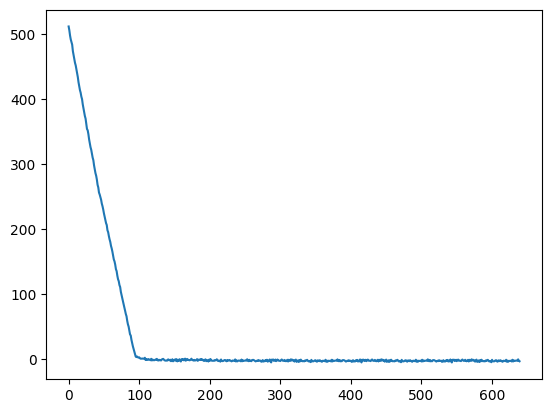

In [16]:
from matplotlib import pyplot as plt
import numpy as np

# optimized_path = os.path.join(
#     env_utils.DEFAULT_RESULTS_DIR,
#     "selection/optimized_backup_heads",
#     mt.name.split("/")[-1],
#     f"{select_task.task_name}.npz"
# )

optimized_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "selection/optimized_heads",
    # mt.name.split("/")[-1],
    model_key.split("/")[-1],
    "distinct_options",
    f"{select_task.task_name}",
    "legacy",
    "epoch_5.npz"
)

optimization_results = np.load(optimized_path, allow_pickle=True)
plt.plot(optimization_results["losses"])
plt.show()

14


(True, True)

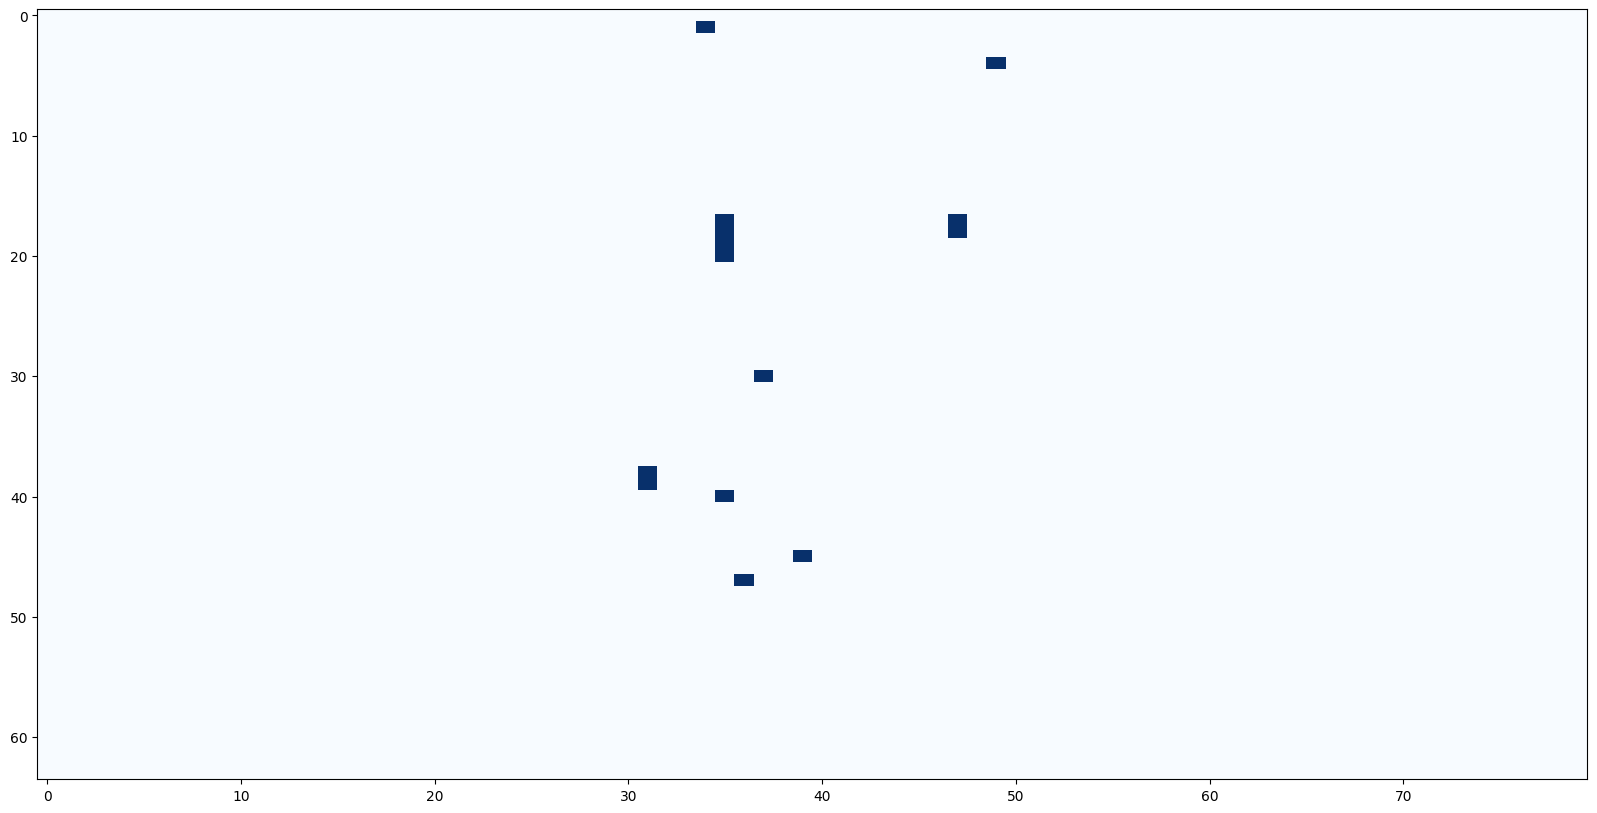

In [17]:
plt.figure(figsize=(20, 10))

optimal_head_mask = torch.tensor(optimization_results["optimal_mask"]).to(torch.float32)
optimal_head_mask[52:, :] = 0.0

plt.imshow(
    optimal_head_mask.T.numpy(),
    cmap="Blues",
    aspect="auto",
    vmin=0,
    vmax=1,
)

optimized_heads = torch.nonzero(optimal_head_mask > 0.5, as_tuple=False).tolist()
optimized_heads = [
    (layer_idx, head_idx) for layer_idx, head_idx in optimized_heads
]
print(len(optimized_heads))

HEADS = optimized_heads

(35, 19) in HEADS, (35, 19) in optimized_heads
# [(29, 3) in HEADS]

In [18]:
# from src.tokens import find_token_range, prepare_input

# string = sample.prompt()
# substring = sample.obj

# tokenized_prompt = prepare_input(
#     prompts=string, 
#     tokenizer=mt.tokenizer, 
#     return_offsets_mapping=True,
#     add_bos_token="qwen" in mt.name.lower()
# )
# string = mt.tokenizer.decode(tokenized_prompt.input_ids[0], skip_special_tokens=False)
# offset_mapping = tokenized_prompt.pop("offset_mapping")[0]

# ans_range = find_token_range(
#     string=string,
#     substring=substring,
#     offset_mapping=offset_mapping
# )
# print(f"Answer range: {ans_range}")
# print(f'"{mt.tokenizer.decode(tokenized_prompt.input_ids[0][range(*ans_range)])}"')
# # for idx, (tok, offset_range) in enumerate(zip(tokenized_prompt.input_ids[0], offset_mapping)):
# #     print(f"Token {idx}: \"{mt.tokenizer.decode([tok])}\" -- {offset_range}")

In [19]:
from src.attention import get_attention_matrices
from src.selection.functional import (
    verify_head_patterns,
    get_patches_to_verify_independent_enrichment,
)

attn_pattern = verify_head_patterns(
    prompt=sample.prompt(option_style="single_line"),
    options=sample.options,
    pivot=sample.subj,
    mt=mt,
    heads=optimized_heads,
    # heads = HEADS,
    # heads = [(29, 3)],
    start_from=1
)

2025-09-09 17:27:57 src.selection.functional DEBUG    Predictions: ['" Mango"[91963] (p=0.887, logit=22.750)', '" The"[578] (p=0.057, logit=20.000)', '" Among"[22395] (p=0.021, logit=19.000)', '" A"[362] (p=0.011, logit=18.375)', '" ("[320] (p=0.005, logit=17.500)']
2025-09-09 17:27:57 src.selection.functional INFO     Combined attention matrix for all heads


In [20]:
import copy
import random
from src.selection.utils import KeyedSet, get_first_token_id, verify_correct_option
from src.selection.data import SelectionSample
from src.functional import predict_next_token
from src.tokens import prepare_input

######################################################################
N_DISTRACTORS = 5
######################################################################

from src.selection.data import get_counterfactual_samples_within_task

In [21]:
patch_prompt_template_idx = 3
clean_prompt_template_idx = 3

patch_sample, clean_sample = get_counterfactual_samples_within_task(
    # patch_category="politician",
    # clean_category="actor",
    mt=mt,
    task=select_task,
    patch_category="fruit",
    clean_category="vehicle",
    prompt_template_idx=prompt_template_idx,
    filter_by_lm_prediction=True,
    distinct_options=True,
    patch_n_distractors=5,
    clean_n_distractors=5,
    patch_prompt_template_idx=patch_prompt_template_idx,
    clean_prompt_template_idx=clean_prompt_template_idx,
    # patch_option_style="single_line",
    # clean_option_style="numbered",
)

clean_sample.metadata

2025-09-09 17:28:07 src.selection.data INFO     clean_obj_idx=2 | ['Cello', 'Basketball', 'Car', 'Strawberry', 'Dog', 'Iris']
type(task)=<class 'src.selection.data.SelectOneTask'>
2025-09-09 17:28:07 src.selection.data INFO     Options: Blueberry, Helmet, Van, Pine, Church, Jacket.
Which among these objects mentioned above is a fruit?
Answer:
2025-09-09 17:28:07 src.selection.data INFO     Pear | fruit -> Blueberry | pred=['" Blue"[8868] (p=0.832, logit=21.875)', '" The"[578] (p=0.078, logit=19.500)', '" Among"[22395] (p=0.037, logit=18.750)', '" A"[362] (p=0.015, logit=17.875)', '" blue"[6437] (p=0.004, logit=16.500)']
2025-09-09 17:28:08 src.selection.data INFO     Options: Cello, Basketball, Car, Strawberry, Dog, Iris.
Which among these objects mentioned above is a vehicle?
Answer:
2025-09-09 17:28:08 src.selection.data INFO     Train | vehicle -> Car | pred=['" Car"[3341] (p=0.668, logit=22.375)', '" The"[578] (p=0.148, logit=20.875)', '" A"[362] (p=0.090, logit=20.375)', '" Among"

{'track_category': 'fruit',
 'track_type_obj': 'Strawberry',
 'track_type_obj_idx': 3,
 'track_type_obj_token_id': 89077,
 'ques_pos': 25,
 'tokenized': {'input_ids': tensor([[128000,   3883,     25,    356,   4896,     11,  47589,     11,   3341,
               11,  89077,     11,  14588,     11,  66821,    627,  23956,   4315,
             1521,   6302,   9932,   3485,    374,    264,   7458,   5380,  16533,
               25]], device='cuda:0'),
  'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
           1, 1, 1, 1]], device='cuda:0')}}

In [22]:
# order_sample_1 = SelectionSample(
#     subj="random",
#     category="test_order",
#     options=["Bike", "Apple", "Bed", "Dog", "Monitor", "Theater"],
#     obj="Apple",
#     obj_idx=1,
#     prompt_template="<_options_>\nWhat is the third item in the list?\nAnswer:",
#     answer="Apple",
# )

# order_sample_2 = SelectionSample(
#     subj="random",
#     category="test_order",
#     options=["Cat", "Chair", "Bus", "Phone", "Library", "Orange"],
#     obj="Phone",
#     obj_idx=3,
#     prompt_template="<_options_>\nWhat is the fifth item in the list?\nAnswer:",
#     answer="Phone",
# )
len(HEADS)

14

In [23]:
from src.functional import generate_with_patch
from src.selection.functional import verify_head_patterns

# patch_sample.options[patch_sample.obj_idx] = "Screw"
# patch_sample.options[patch_sample.obj_idx] = patch_sample.obj

gold_sample = copy.deepcopy(patch_sample)
gold_sample.options = clean_sample.options

for sample in [patch_sample, clean_sample, gold_sample]:
# for sample in [order_sample_1, order_sample_2]:
    print(sample.prompt(), ">>", sample.obj)
    attn_pattern = verify_head_patterns(
        prompt=sample.prompt(),
        options=sample.options,
        pivot=sample.subj,
        mt=mt,
        # heads=qwen_72_heads,
        heads=optimized_heads,
        # heads=[(layer_idx, head_idx)],
        # generate_full_answer=True,
        query_index=-1
    )

Options: Blueberry, Helmet, Van, Pine, Church, Jacket.
Which among these objects mentioned above is a fruit?
Answer: >> Blueberry
2025-09-09 17:28:09 src.selection.functional DEBUG    Predictions: ['" Blue"[8868] (p=0.832, logit=21.875)', '" The"[578] (p=0.078, logit=19.500)', '" Among"[22395] (p=0.037, logit=18.750)', '" A"[362] (p=0.015, logit=17.875)', '" blue"[6437] (p=0.004, logit=16.500)']
2025-09-09 17:28:09 src.selection.functional INFO     Combined attention matrix for all heads


Options: Cello, Basketball, Car, Strawberry, Dog, Iris.
Which among these objects mentioned above is a vehicle?
Answer: >> Car
2025-09-09 17:28:10 src.selection.functional DEBUG    Predictions: ['" Car"[3341] (p=0.668, logit=22.375)', '" The"[578] (p=0.148, logit=20.875)', '" A"[362] (p=0.090, logit=20.375)', '" Among"[22395] (p=0.042, logit=19.625)', '" C"[356] (p=0.014, logit=18.500)']
2025-09-09 17:28:10 src.selection.functional INFO     Combined attention matrix for all heads


Options: Cello, Basketball, Car, Strawberry, Dog, Iris.
Which among these objects mentioned above is a fruit?
Answer: >> Blueberry
2025-09-09 17:28:10 src.selection.functional DEBUG    Predictions: ['" Strawberry"[89077] (p=0.629, logit=21.250)', '" The"[578] (p=0.180, logit=20.000)', '" Among"[22395] (p=0.085, logit=19.250)', '" A"[362] (p=0.058, logit=18.875)', '" strawberry"[73700] (p=0.004, logit=16.250)']
2025-09-09 17:28:10 src.selection.functional INFO     Combined attention matrix for all heads


In [24]:
clean_sample.metadata, patch_sample.metadata

({'track_category': 'fruit',
  'track_type_obj': 'Strawberry',
  'track_type_obj_idx': 3,
  'track_type_obj_token_id': 89077,
  'ques_pos': 25,
  'tokenized': {'input_ids': tensor([[128000,   3883,     25,    356,   4896,     11,  47589,     11,   3341,
                11,  89077,     11,  14588,     11,  66821,    627,  23956,   4315,
              1521,   6302,   9932,   3485,    374,    264,   7458,   5380,  16533,
                25]], device='cuda:0'),
   'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
            1, 1, 1, 1]], device='cuda:0')}},
 {'track_category': 'vehicle',
  'track_type_obj': 'Van',
  'track_type_obj_idx': 2,
  'track_type_obj_token_id': 13000,
  'ques_pos': 25,
  'tokenized': {'input_ids': tensor([[128000,   3883,     25,   8868,  15717,     11,  67629,     11,  13000,
                11,  42609,     11,   9441,     11,  55870,    627,  23956,   4315,
              1521,   6302,   9932,   3485,    374,    26

In [25]:
from src.selection.functional import cache_q_projections
from src.functional import interpret_logits
from src.tokens import prepare_input, find_token_range

prompts = [
    patch_sample.prompt(),
    clean_sample.prompt(),
]

tokenized = prepare_input(
    prompts=prompts,
    tokenizer=mt.tokenizer,
    return_offsets_mapping=True,
)

offset_mapping = tokenized.pop("offset_mapping")

question_ranges = [
    find_token_range(
        string=prompt,
        substring="?",
        occurrence=-1,
        offset_mapping=offset,
    )
    for prompt, offset in zip(prompts, offset_mapping)
]
ques_pos = [rng[1]-1 for rng in question_ranges]
for tok, q_pos in zip(tokenized.input_ids, ques_pos):
    assert mt.tokenizer.decode(tok[q_pos]).strip() == "?"

q_projections, out = cache_q_projections(
    mt=mt,
    input=tokenized,
    heads=HEADS,
    token_indices=[ [q_pos, -2, -1] for q_pos in ques_pos],
    return_output=True
)

In [26]:
tokenized

{'input_ids': tensor([[128000,   3883,     25,   8868,  15717,     11,  67629,     11,  13000,
             11,  42609,     11,   9441,     11,  55870,    627,  23956,   4315,
           1521,   6302,   9932,   3485,    374,    264,  14098,   5380,  16533,
             25],
        [128000,   3883,     25,    356,   4896,     11,  47589,     11,   3341,
             11,  89077,     11,  14588,     11,  66821,    627,  23956,   4315,
           1521,   6302,   9932,   3485,    374,    264,   7458,   5380,  16533,
             25]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1]])}

In [27]:
patch_logits = out.logits[0, -1, :]
interpret_logits(
    logits=patch_logits,
    tokenizer=mt.tokenizer,
)

[PredictedToken(token=' Blue', prob=0.8515625, logit=22.0, token_id=8868, metadata=None),
 PredictedToken(token=' The', prob=0.06982421875, logit=19.5, token_id=578, metadata=None),
 PredictedToken(token=' Among', prob=0.032958984375, logit=18.75, token_id=22395, metadata=None),
 PredictedToken(token=' A', prob=0.01373291015625, logit=17.875, token_id=362, metadata=None),
 PredictedToken(token=' blue', prob=0.00347900390625, logit=16.5, token_id=6437, metadata=None)]

In [28]:
patch_logits = out.logits[1, -1, :]
interpret_logits(
    logits=patch_logits,
    tokenizer=mt.tokenizer,
)

[PredictedToken(token=' Car', prob=0.66015625, logit=22.375, token_id=3341, metadata=None),
 PredictedToken(token=' The', prob=0.146484375, logit=20.875, token_id=578, metadata=None),
 PredictedToken(token=' A', prob=0.10107421875, logit=20.5, token_id=362, metadata=None),
 PredictedToken(token=' Among', prob=0.0419921875, logit=19.625, token_id=22395, metadata=None),
 PredictedToken(token=' C', prob=0.013671875, logit=18.5, token_id=356, metadata=None)]

In [29]:
q_projections[1].keys()

dict_keys([(31, 38, 25), (31, 38, -2), (31, 38, -1), (31, 39, 25), (31, 39, -2), (31, 39, -1), (34, 1, 25), (34, 1, -2), (34, 1, -1), (35, 17, 25), (35, 17, -2), (35, 17, -1), (35, 18, 25), (35, 18, -2), (35, 18, -1), (35, 19, 25), (35, 19, -2), (35, 19, -1), (35, 20, 25), (35, 20, -2), (35, 20, -1), (35, 40, 25), (35, 40, -2), (35, 40, -1), (36, 47, 25), (36, 47, -2), (36, 47, -1), (37, 30, 25), (37, 30, -2), (37, 30, -1), (39, 45, 25), (39, 45, -2), (39, 45, -1), (47, 17, 25), (47, 17, -2), (47, 17, -1), (47, 18, 25), (47, 18, -2), (47, 18, -1), (49, 4, 25), (49, 4, -2), (49, 4, -1)])

## Testing patching the query projection of a single head

In [30]:
# from src.selection.functional import cache_q_projections
from src.functional import patch_with_baukit, PatchSpec, repeat_kv, get_module_nnsight
from src.utils.typing import TokenizerOutput, Tokenizer
from src.selection.functional import cache_q_projections, verify_head_patterns

def find_quesmark_pos(
    prompt: str, 
    tokenizer: Tokenizer,
    tokenized: TokenizerOutput,
    offset_mapping: list[tuple[int, int]] | None = None,
    ques_mark: str = "?",
):
    if offset_mapping is None:
        if tokenized is None or "offset_mapping" not in tokenized:
            tokenized = prepare_input(
                prompts=[prompt], 
                tokenizer=tokenizer, 
                return_offsets_mapping=True,
            )
        offset_mapping = tokenized.pop("offset_mapping")[0]
    
    ques_range = find_token_range(
        string=prompt,
        substring=ques_mark,
        occurrence=-1,
        offset_mapping=offset_mapping
    )
    ques_pos = ques_range[1]-1
    assert tokenizer.decode(tokenized.input_ids[0][ques_pos]).strip() == ques_mark
    return ques_pos

mt.set_attn_implementation("eager")
mt.reset_forward()

# test_heads = [(35, 19)]
test_heads = copy.deepcopy(optimized_heads)

patch_tokenized = prepare_input(
    prompts=patch_sample.prompt(), 
    tokenizer=mt,
    return_offsets_mapping=True
)
patch_offsets = patch_tokenized.pop("offset_mapping")[0]
patch_ques_pos = find_quesmark_pos(
    prompt=patch_sample.prompt(),
    tokenizer=mt.tokenizer,
    tokenized=patch_tokenized,
    offset_mapping=patch_offsets
)

clean_tokenized = prepare_input(
    prompts=clean_sample.prompt(), 
    tokenizer=mt,
    return_offsets_mapping=True
)
clean_offsets = clean_tokenized.pop("offset_mapping")[0]
clean_ques_pos = find_quesmark_pos(
    prompt=clean_sample.prompt(),
    tokenizer=mt.tokenizer,
    tokenized=clean_tokenized,
    offset_mapping=clean_offsets
)

# indices = [patch_ques_pos, -2, -1]
indices = [-3, -2, -1]

q_states = cache_q_projections(
    mt=mt,
    input=patch_tokenized,
    heads=test_heads,
    token_indices=[indices],
)[0]

# map_indices = {patch_ques_pos: clean_ques_pos, -2: -2, -1: -1}
map_indices = {-3: -3, -2: -2, -1: -1}
q_patches = []
for (l_idx, h_idx, patch_token_idx), q_proj in q_states.items():
    q_patches.append(PatchSpec(
        location=(
            mt.attn_module_name_format.format(l_idx)+".q_proj",
            h_idx,
            map_indices[patch_token_idx]
        ),
        patch=q_proj.squeeze()
    ))

# The attention patterns for the patch sample should match exactly
test_inplace_swap = verify_head_patterns(
    prompt=patch_sample.prompt(),
    mt=mt,
    heads=test_heads,
    # heads=qwen_72_heads,
    tokenized_prompt=patch_tokenized,
    query_patches=q_patches
)

test_predicate_swap = verify_head_patterns(
    prompt=clean_sample.prompt(),
    mt=mt,
    heads=test_heads,
    # heads=qwen_72_heads,
    tokenized_prompt=clean_tokenized,
    query_patches=q_patches
)

2025-09-09 17:28:49 src.selection.functional DEBUG    Predictions: ['" Blue"[8868] (p=0.832, logit=21.875)', '" The"[578] (p=0.078, logit=19.500)', '" Among"[22395] (p=0.037, logit=18.750)', '" A"[362] (p=0.015, logit=17.875)', '" blue"[6437] (p=0.004, logit=16.500)']
2025-09-09 17:28:49 src.selection.functional INFO     Combined attention matrix for all heads


2025-09-09 17:28:50 src.selection.functional DEBUG    Predictions: ['" Strawberry"[89077] (p=0.301, logit=19.625)', '" Among"[22395] (p=0.161, logit=19.000)', '" Car"[3341] (p=0.161, logit=19.000)', '" The"[578] (p=0.161, logit=19.000)', '" None"[2290] (p=0.059, logit=18.000)']
2025-09-09 17:28:50 src.selection.functional INFO     Combined attention matrix for all heads


In [31]:
(
    (patch_ques_pos, mt.tokenizer.decode(patch_tokenized.input_ids[0][patch_ques_pos])),
    (clean_ques_pos, mt.tokenizer.decode(clean_tokenized.input_ids[0][clean_ques_pos]))
)

((25, '?\n'), (25, '?\n'))

In [32]:
clean_tokenized.input_ids.shape

torch.Size([1, 28])

In [38]:
import baukit
from src.functional import get_module_nnsight, PatchSpec
from src.hooking.llama_attention import LlamaAttentionPatcher
import types
from typing import Literal
from src.tokens import prepare_input


def set_attn_implementation(mt, attn_implementation: Literal["sdpa", "eager"]):
    mt.config._attn_implementation = attn_implementation
    for layer_idx in range(mt.config.num_hidden_layers):
        attn_block_name = mt.attn_module_name_format.format(layer_idx)
        attn_block = baukit.get_module(mt._model, attn_block_name)
        attn_block.config._attn_implementation = attn_implementation


###################################################################################
batch_size = 1  # tokenized.input_ids.shape[0]
n_heads = mt.config.num_attention_heads
head_dim = mt.n_embd // n_heads
query_idx = -1 # almost always the last token
###################################################################################

mt.reset_forward()
set_attn_implementation(mt, "sdpa")

layer_idx, head_idx = HEADS[0]

attn_block_name = mt.attn_module_name_format.format(layer_idx)
attn_block = baukit.get_module(mt._model, attn_block_name)
attn_block.forward = types.MethodType(
    LlamaAttentionPatcher(block_name=attn_block_name),
    attn_block,
)

patch_tokenized = prepare_input(prompts=patch_sample.prompt(), tokenizer=mt)
patch_seq_len = patch_tokenized.input_ids.shape[1]
input_ln = mt.layer_name_format.format(layer_idx) + ".input_layernorm"

with mt.trace(patch_tokenized) as trace:
    ln_module = get_module_nnsight(mt, input_ln)
    patch_ln = ln_module.output.save()

    q_proj_name = mt.attn_module_name_format.format(layer_idx) + ".q_proj"
    q_proj_module = get_module_nnsight(mt, q_proj_name)
    patch_q_proj = q_proj_module.output.view(batch_size, patch_seq_len, n_heads, head_dim).transpose(1, 2).save()
    # patch_q_proj = PatchSpec(
    #     location=(q_proj_name + f".{head_idx}", -1),
    #     patch=patch_q_proj[:, head_idx, query_idx, :].squeeze().save()
    # )

clean_tokenized = prepare_input(prompts=clean_sample.prompt(), tokenizer=mt)
clean_seq_len = clean_tokenized.input_ids.shape[1]
with mt.trace(clean_tokenized) as trace:
    ln_module = get_module_nnsight(mt, input_ln)
    clean_ln = ln_module.output.save()

    q_proj_name = mt.attn_module_name_format.format(layer_idx) + ".q_proj"
    q_proj_module = get_module_nnsight(mt, q_proj_name)
    clean_q_proj = q_proj_module.output.view(batch_size, clean_seq_len, n_heads, head_dim).transpose(1, 2).save()
    # clean_q_proj = PatchSpec(
    #     location=(q_proj_name + f".{head_idx}", -1),
    #     patch=clean_q_proj[:, head_idx, query_idx, :].squeeze().save()
    # )

mt.reset_forward()
set_attn_implementation(mt, "eager")

patch_q_proj.shape, clean_q_proj.shape, patch_ln.shape, clean_ln.shape

NNsightException: 

Traceback (most recent call last):
  File "/tmp/ipykernel_892520/3560673123.py", line 84, in <module>
    patch_q_proj = q_proj_module.output.view(batch_size, patch_seq_len, n_heads, head_dim).transpose(1, 2).save()

RuntimeError: shape '[1, 30, 32, 144]' is invalid for input of size 122880

In [ ]:
from src.attention import visualize_attn_matrix
from src.functional import get_hs, interpret_logits

mt.reset_forward()
set_attn_implementation(mt, "sdpa")

layer_idx, head_idx = 35, 19
# layer_idx, head_idx = 62, 1

attn_matrices = {layer_idx: {}}

attn_block_name = mt.attn_module_name_format.format(layer_idx)
attn_block = baukit.get_module(mt._model, attn_block_name)
attn_block.forward = types.MethodType(
    LlamaAttentionPatcher(
        block_name=attn_block_name,
        save_attn_for=[head_idx],
        store_attn_matrices=attn_matrices[layer_idx],
    ),
    attn_block,
)

logit_location = (mt.lm_head_name, -1)
logits = get_hs(
    mt = mt,
    input = clean_tokenized,
    locations = [logit_location],
    return_dict=False
).squeeze()  # (seq_len, vocab_size)

mt.reset_forward()
set_attn_implementation(mt, "eager")

head_matrix = attn_matrices[layer_idx][head_idx].squeeze().to(torch.float32).cpu().numpy()

visualize_attn_matrix(
    attn_matrix=head_matrix,
    tokens=[mt.tokenizer.decode(t) for t in clean_tokenized.input_ids[0]],
    q_index=-1,
)

interpret_logits(
    tokenizer=mt,
    logits=logits,
    interested_tokens=[clean_sample.metadata["track_type_obj_token_id"]],
)

In [ ]:
# type(mt._model), query_idx
head_idx, query_idx, patch_q_proj[:, head_idx, query_idx, :].shape

In [ ]:
from src.attention import visualize_attn_matrix

mt.reset_forward()
set_attn_implementation(mt, "sdpa")

attn_matrices = {layer_idx: {}}

attn_block_name = mt.attn_module_name_format.format(layer_idx)
attn_block = baukit.get_module(mt._model, attn_block_name)
attn_block.forward = types.MethodType(
    LlamaAttentionPatcher(
        block_name=attn_block_name,
        save_attn_for=[head_idx],
        store_attn_matrices=attn_matrices[layer_idx],
        query_patches=[(head_idx, query_idx, patch_q_proj[:, head_idx, query_idx, :].squeeze())],
    ),
    attn_block,
)

logit_location = (mt.lm_head_name, -1)
patch_logits = get_hs(
    mt = mt,
    # input = clean_tokenized,
    input=patch_tokenized,
    locations = [logit_location],
    return_dict=False
).squeeze()  # (seq_len, vocab_size)

mt.reset_forward()
set_attn_implementation(mt, "eager")

head_matrix = attn_matrices[layer_idx][head_idx].squeeze().to(torch.float32).cpu().numpy()

visualize_attn_matrix(
    attn_matrix=head_matrix,
    # tokens=[mt.tokenizer.decode(t) for t in clean_tokenized.input_ids[0]],
    tokens=[mt.tokenizer.decode(t) for t in patch_tokenized.input_ids[0]],
    q_index=-1,
)

interpret_logits(
    tokenizer=mt,
    logits=patch_logits,
    interested_tokens=[clean_sample.metadata["track_type_obj_token_id"]],
)

In [ ]:
torch.allclose(patch_logits, logits, atol = 1e-3)

In [ ]:
torch.allclose(
    patch_q_proj[:, head_idx, query_idx, :], 
    clean_q_proj[:, head_idx, query_idx, :],
    atol=1e-3
)

In [ ]:
# torch.allclose(
#     patch_ln[:, query_idx, :], 
#     clean_ln[:, query_idx, :],
#     atol=1e-3
# )

In [ ]:
# patch_ln[:, query_idx, :], clean_ln[:, query_idx, :]

In [ ]:
# # manual calculation
# attn_module = baukit.get_module(mt._model, mt.attn_module_name_format.format(layer_idx))
# patch_q_proj_manual = attn_module.q_proj(patch_ln)
# clean_q_proj_manual = attn_module.q_proj(clean_ln)

# print(patch_q_proj_manual.shape, clean_q_proj_manual.shape)
# print(torch.allclose(
#     patch_q_proj_manual[:, query_idx, :], 
#     clean_q_proj_manual[:, query_idx, :],
#     atol=1e-3
# ))

# patch_q_proj_manual = patch_q_proj_manual.reshape(batch_size, patch_seq_len, n_heads, head_dim).transpose(1, 2)
# clean_q_proj_manual = clean_q_proj_manual.reshape(batch_size, clean_seq_len, n_heads, head_dim).transpose(1, 2)
# print(patch_q_proj_manual.shape, clean_q_proj_manual.shape)

# for idx in range(n_heads):
#     print(head_idx, torch.allclose(
#         patch_q_proj_manual[:, idx, query_idx, :], 
#         clean_q_proj_manual[:, idx, query_idx, :],
#         atol=1e-3
#     ))

In [ ]:
# torch.allclose(
#     patch_q_proj_manual[:, head_idx, query_idx, :], 
#     patch_q_proj[:, head_idx, query_idx, :],
#     atol=1e-3
# )

In [ ]:
replace_q_proj = clean_q_proj.clone()
replace_q_proj[:, head_idx, query_idx, :] = patch_q_proj[:, head_idx, query_idx, :]

print(torch.allclose(
        replace_q_proj[:, head_idx, query_idx, :],
        clean_q_proj[:, head_idx, query_idx, :],
        atol=1e-3
    )
)
print(replace_q_proj.shape)

replace_q_proj = replace_q_proj.transpose(1, 2).reshape(batch_size, clean_seq_len, -1)

rep_patch = PatchSpec(
    location=(q_proj_name, -1),
    patch=replace_q_proj[:, -1, :].squeeze(),
)

ln_patch = PatchSpec(
    location=(input_ln, -1),
    patch=patch_ln[:, query_idx, :].squeeze(),
)

head_q_patch = PatchSpec(
    location=(q_proj_name, head_idx, -1),
    patch=patch_q_proj[:, head_idx, query_idx, :].squeeze(),
)

head_q_patch.location, rep_patch.location

In [ ]:
# clean_q_proj_rs = clean_q_proj.view(batch_size, clean_seq_len, -1)
# patch_q_proj_rs = patch_q_proj.view(batch_size, clean_seq_len, -1)
# clean_q_proj_rs[:, -1, :].shape, patch_q_proj_rs[:, -1, :].shape

In [ ]:
# torch.allclose(
#     replace_q_proj[:, -1, :].squeeze(), 
#     # patch_q_proj_rs[:, -1, :].squeeze(),
#     clean_q_proj_rs[:, -1, :].squeeze(), 
#     atol=1e-3
# )

In [ ]:
patch_q_proj.shape, clean_q_proj.shape
# torch.allclose(patch_q_proj.patch, clean_q_proj.patch)

In [ ]:
clean_sample.metadata

In [ ]:
from src.attention import get_attention_matrices, visualize_attn_matrix
from src.functional import interpret_logits

clean_tokenized = prepare_input(prompts=clean_sample.prompt(), tokenizer=mt)

attn_info = get_attention_matrices(
    input=clean_tokenized,
    mt=mt,
)

attn_matrix = attn_info.attention_matrices[layer_idx, head_idx].squeeze()
visualize_attn_matrix(
    attn_matrix=attn_matrix,
    tokens=[mt.tokenizer.decode(t) for t in clean_tokenized.input_ids[0]],
    q_index=-1,
)

interpret_logits(
    tokenizer=mt,
    logits=attn_info.logits,
    interested_tokens=[clean_sample.ans_token_id, clean_sample.metadata["track_type_obj_token_id"]]
)

In [ ]:
from src.attention import get_attention_matrices, visualize_attn_matrix
from src.functional import patch_with_nnsight, patch_with_baukit

clean_tokenized = prepare_input(prompts=clean_sample.prompt(), tokenizer=mt)

patched_attn_info = get_attention_matrices(
    input=clean_tokenized,
    mt=mt,
    # patches=[ln_patch],
    patches = [head_q_patch],
    # patches = [rep_patch],
    # patch_interface=patch_with_nnsight
    patch_interface=patch_with_baukit
)

patched_attn_matrix = patched_attn_info.attention_matrices[layer_idx, head_idx].squeeze()
visualize_attn_matrix(
    attn_matrix=patched_attn_matrix,
    tokens=[mt.tokenizer.decode(t) for t in clean_tokenized.input_ids[0]],
    q_index=-1,
)

interpret_logits(
    tokenizer=mt,
    logits=patched_attn_info.logits,
    interested_tokens=[clean_sample.ans_token_id, clean_sample.metadata["track_type_obj_token_id"]]
)

## Patching a bunch of heads

### Loading the Heads

#### Attention Behavior

In [62]:
from scripts.locate_via_attention_behavior import SelectionSampleAttn
attn_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "selection/attention_patterns/select_one",
    # mt.name.split("/")[-1],
    model_key.split("/")[-1],
    "objects"
)
files = sorted(os.listdir(attn_path))
print(files)

#######################################################################
# LIMIT = 512
LIMIT = len(files)
#######################################################################

selection_attns = []

for npz_file in files[:LIMIT]:
    if not npz_file.endswith(".npz"):
        continue

    npz_path = os.path.join(attn_path, npz_file)
    selection_attns.append(SelectionSampleAttn.from_npz(npz_path))
    if len(selection_attns) % 128 == 0:
        print(f"Loaded {len(selection_attns)}/{LIMIT} files")

len(selection_attns)

['sample_0000.npz', 'sample_0001.npz', 'sample_0002.npz', 'sample_0003.npz', 'sample_0004.npz', 'sample_0005.npz', 'sample_0006.npz', 'sample_0007.npz', 'sample_0008.npz', 'sample_0009.npz', 'sample_0010.npz', 'sample_0011.npz', 'sample_0012.npz', 'sample_0013.npz', 'sample_0014.npz', 'sample_0015.npz', 'sample_0016.npz', 'sample_0017.npz', 'sample_0018.npz', 'sample_0019.npz', 'sample_0020.npz', 'sample_0021.npz', 'sample_0022.npz', 'sample_0023.npz', 'sample_0024.npz', 'sample_0025.npz', 'sample_0026.npz', 'sample_0027.npz', 'sample_0028.npz', 'sample_0029.npz', 'sample_0030.npz', 'sample_0031.npz', 'sample_0032.npz', 'sample_0033.npz', 'sample_0034.npz', 'sample_0035.npz', 'sample_0036.npz', 'sample_0037.npz', 'sample_0038.npz', 'sample_0039.npz', 'sample_0040.npz', 'sample_0041.npz', 'sample_0042.npz', 'sample_0043.npz', 'sample_0044.npz', 'sample_0045.npz', 'sample_0046.npz', 'sample_0047.npz', 'sample_0048.npz', 'sample_0049.npz', 'sample_0050.npz', 'sample_0051.npz', 'sample_005

2048

In [63]:
from src.attention import visualize_attn_matrix

sample_idx = 145

# layer_idx, head_idx = 35, 19 # llama-70B
layer_idx, head_idx = 54, 44 # qwen-72B
# layer_idx, head_idx = 51, 11 # qwen-32B
# layer_idx, head_idx = 29, 3 # gemma-27b


selection_attn = selection_attns[sample_idx]
print(selection_attn.resolution_score(layer_idx, head_idx))
visualize_attn_matrix(
    attn_matrix=selection_attn.attention_pattern.attention_matrices[layer_idx, head_idx],
    tokens=selection_attn.attention_pattern.tokenized_prompt,
    q_index=-1,
    start_from=1,
)

(0.7007384896278381, 0.703125, [0.0022249221801757812, 0.000152587890625, 3.790855407714844e-05, 7.361173629760742e-06, 0.0023865103721618652])


In [64]:
selection_attns[0].attention_pattern.attention_matrices.shape

(80, 64, 32, 32)

In [65]:
from tqdm.auto import tqdm

#############################################################################
n_layer = selection_attns[0].attention_pattern.attention_matrices.shape[0]
n_head = selection_attns[0].attention_pattern.attention_matrices.shape[1]
# token_idx = "all"
token_idx = "last"
##############################################################################

resolution_scores = torch.zeros((n_head, n_layer), dtype=torch.float32)
for selection_attn in tqdm(selection_attns):
    for layer_idx in range(n_layer):
        for head_idx in range(n_head):
            resolution_scores[head_idx, layer_idx] += selection_attn.resolution_score(
                layer_idx, head_idx, token_idx=token_idx
            )[0]
            # resolution_scores[head_idx, layer_idx] += selection_attn.first_token_score(
            #     layer_idx, head_idx
            # )[0]

resolution_scores /= len(selection_attns)
resolution_scores.shape

  0%|          | 0/2048 [00:00<?, ?it/s]

torch.Size([64, 80])

2025-08-31 21:26:10 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7fba4cd20d50>


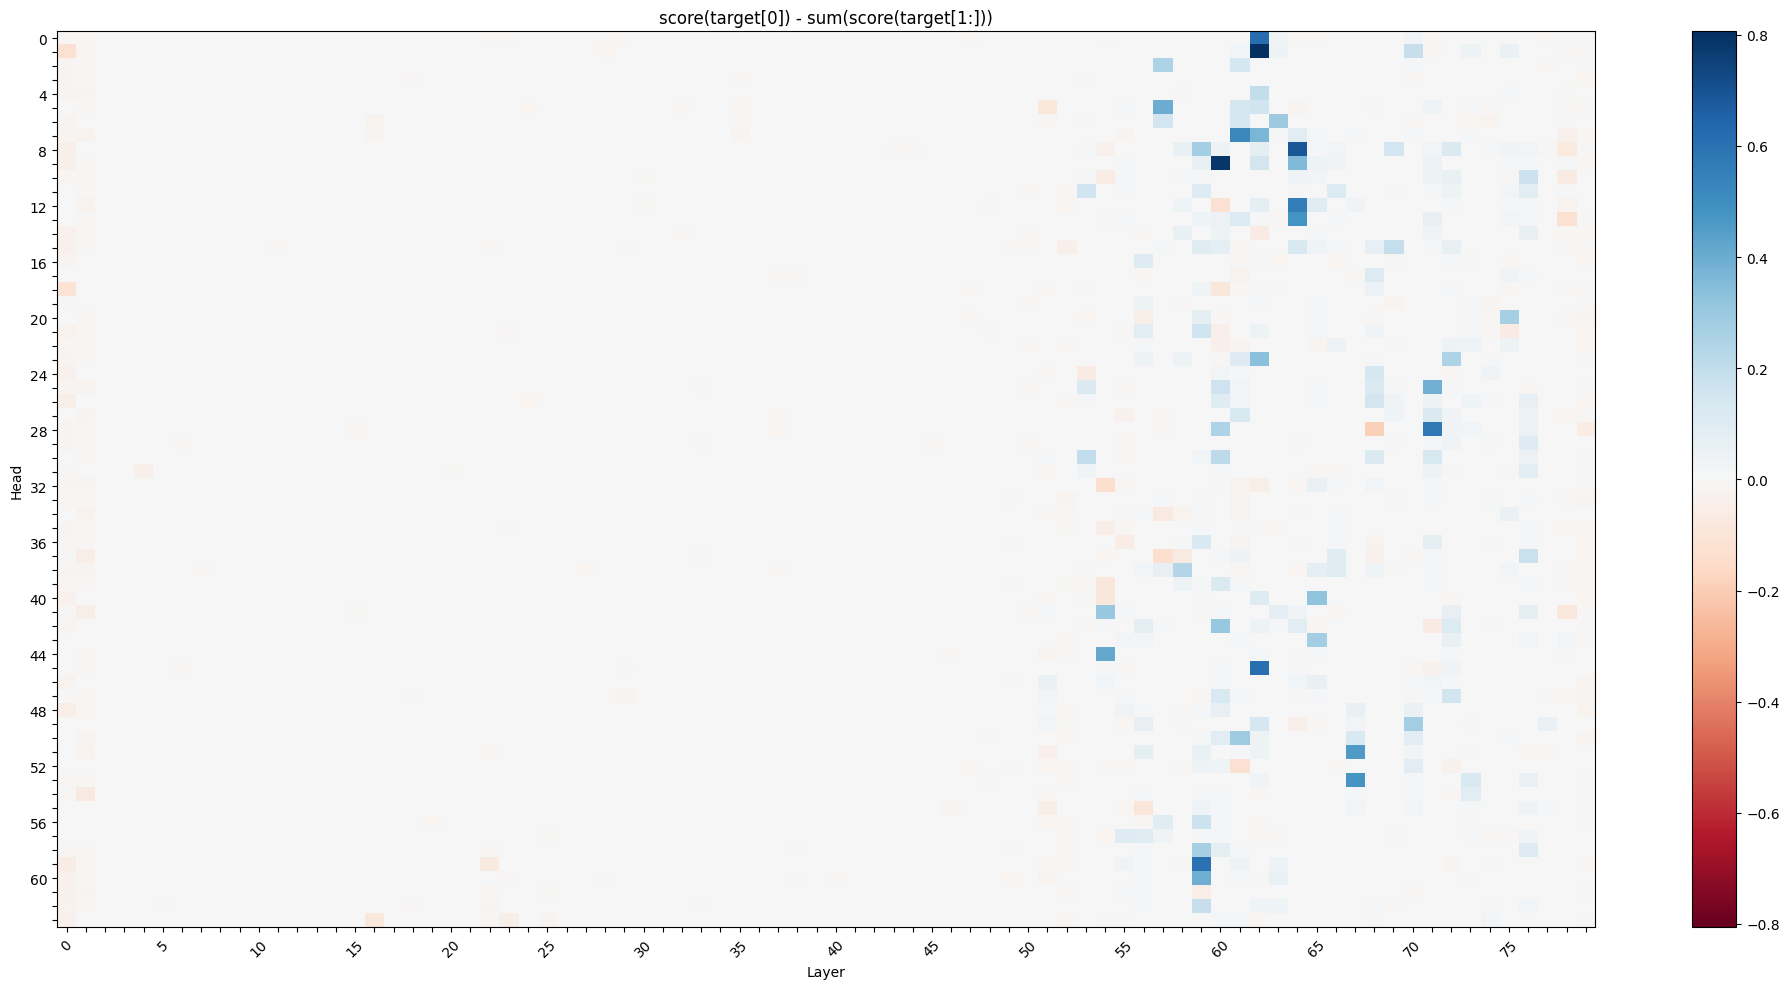

Layer 62, Head 1: 0.8061
Layer 60, Head 9: 0.7835
Layer 64, Head 8: 0.6922
Layer 62, Head 0: 0.6163
Layer 62, Head 45: 0.6103
Layer 59, Head 59: 0.6028
Layer 71, Head 28: 0.5789
Layer 64, Head 12: 0.5582
Layer 61, Head 7: 0.5225
Layer 64, Head 13: 0.4823
Layer 67, Head 53: 0.4784
Layer 67, Head 51: 0.4590
Layer 54, Head 44: 0.4103
Layer 57, Head 5: 0.3988
Layer 59, Head 60: 0.3927


In [66]:
from matplotlib import pyplot as plt

plt.figure(figsize=(20, 10))
scale = torch.max(torch.abs(resolution_scores))
plt.imshow(
    resolution_scores.cpu().numpy(),
    cmap="RdBu",
    aspect="auto",
    vmin=-scale,
    vmax=scale,
)
plt.colorbar()
# plt.title(f"score(target) - max(score(distractors)) | {token_idx.upper()} tokens of options")
plt.title("score(target[0]) - sum(score(target[1:]))")
plt.xlabel("Layer")
plt.ylabel("Head")

def get_ticks(ticks, skip=5):
    ret = []
    for i in ticks:
        if i % skip == 0:
            ret.append(str(i))
        else:
            ret.append("")
    return ret

plt.xticks(
    ticks=range(n_layer),
    labels=get_ticks(range(n_layer)),
    rotation=45,
)
plt.yticks(
    ticks=range(n_head),
    labels=get_ticks(range(n_head), skip=4),
)

plt.tight_layout()
plt.show()


scores_per_head = []
for head_idx in range(n_head):
    for layer_idx in range(n_layer):
        scores_per_head.append(
            (head_idx, layer_idx, resolution_scores[head_idx, layer_idx].item())
        )

scores_per_head = sorted(scores_per_head, key=lambda x: x[2], reverse=True)
for head_idx, layer_idx, score in scores_per_head[:15]:
    print(f"Layer {layer_idx}, Head {head_idx}: {score:.4f}")

In [30]:
heads_attn_behavior = [(layer_idx, head_idx) for head_idx, layer_idx, score in scores_per_head[:20]]
print(heads_attn_behavior)

[(51, 11), (48, 4), (52, 21), (54, 35), (48, 8), (50, 6), (48, 9), (48, 32), (52, 10), (45, 11), (45, 13), (48, 34), (53, 16), (50, 12), (49, 2), (54, 38), (55, 4), (50, 27), (54, 33), (50, 14)]


#### Based on Patching Score

In [22]:
from scripts.patching_within_task import SelectionQprojPatchResult
from tqdm.auto import tqdm


q_proj_root = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "selection/q_states_patching",
    # mt.name.split("/")[-1],
    model_key.split("/")[-1],
)

#############################################
# LIMIT = 20
LIMIT = None
# n_layer = mt.n_layer
# n_head = mt.config.num_attention_heads
categories = [
    # "profession",
    # "nationality",
    "objects",
]
#############################################

q_proj_results = {cat: [] for cat in categories}

for category in categories:
    print(f"category: {category}")
    q_proj_path = os.path.join(q_proj_root, category)
    files = sorted(os.listdir(q_proj_path))
    LIMIT = LIMIT or len(files)
    q_proj_results[category] = []
    for file in tqdm(files[:LIMIT]):
        if not file.endswith(".json"):
            continue

        file_path = os.path.join(q_proj_path, file)
        q_proj_results[category].append(SelectionQprojPatchResult.load_from_json(file_path))
        # if len(q_proj_results) % 10 == 0:
        #     print(f"Loaded {len(q_proj_results)}/{LIMIT} files")



category: objects


  0%|          | 0/150 [00:00<?, ?it/s]

In [26]:
import copy
combine_all_results = []
for category in categories:
    combine_all_results.extend(q_proj_results[category])

results_copy = copy.deepcopy(q_proj_results)
results_copy["all"] = combine_all_results

In [27]:
len(results_copy["objects"])

150

In [32]:
heads = combine_all_results[0].headwise_patching_effects.keys()
layers = set([layer for layer, head in heads])
heads = set([head for layer, head in heads])    

2025-08-31 20:30:21 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7fba78acab50>


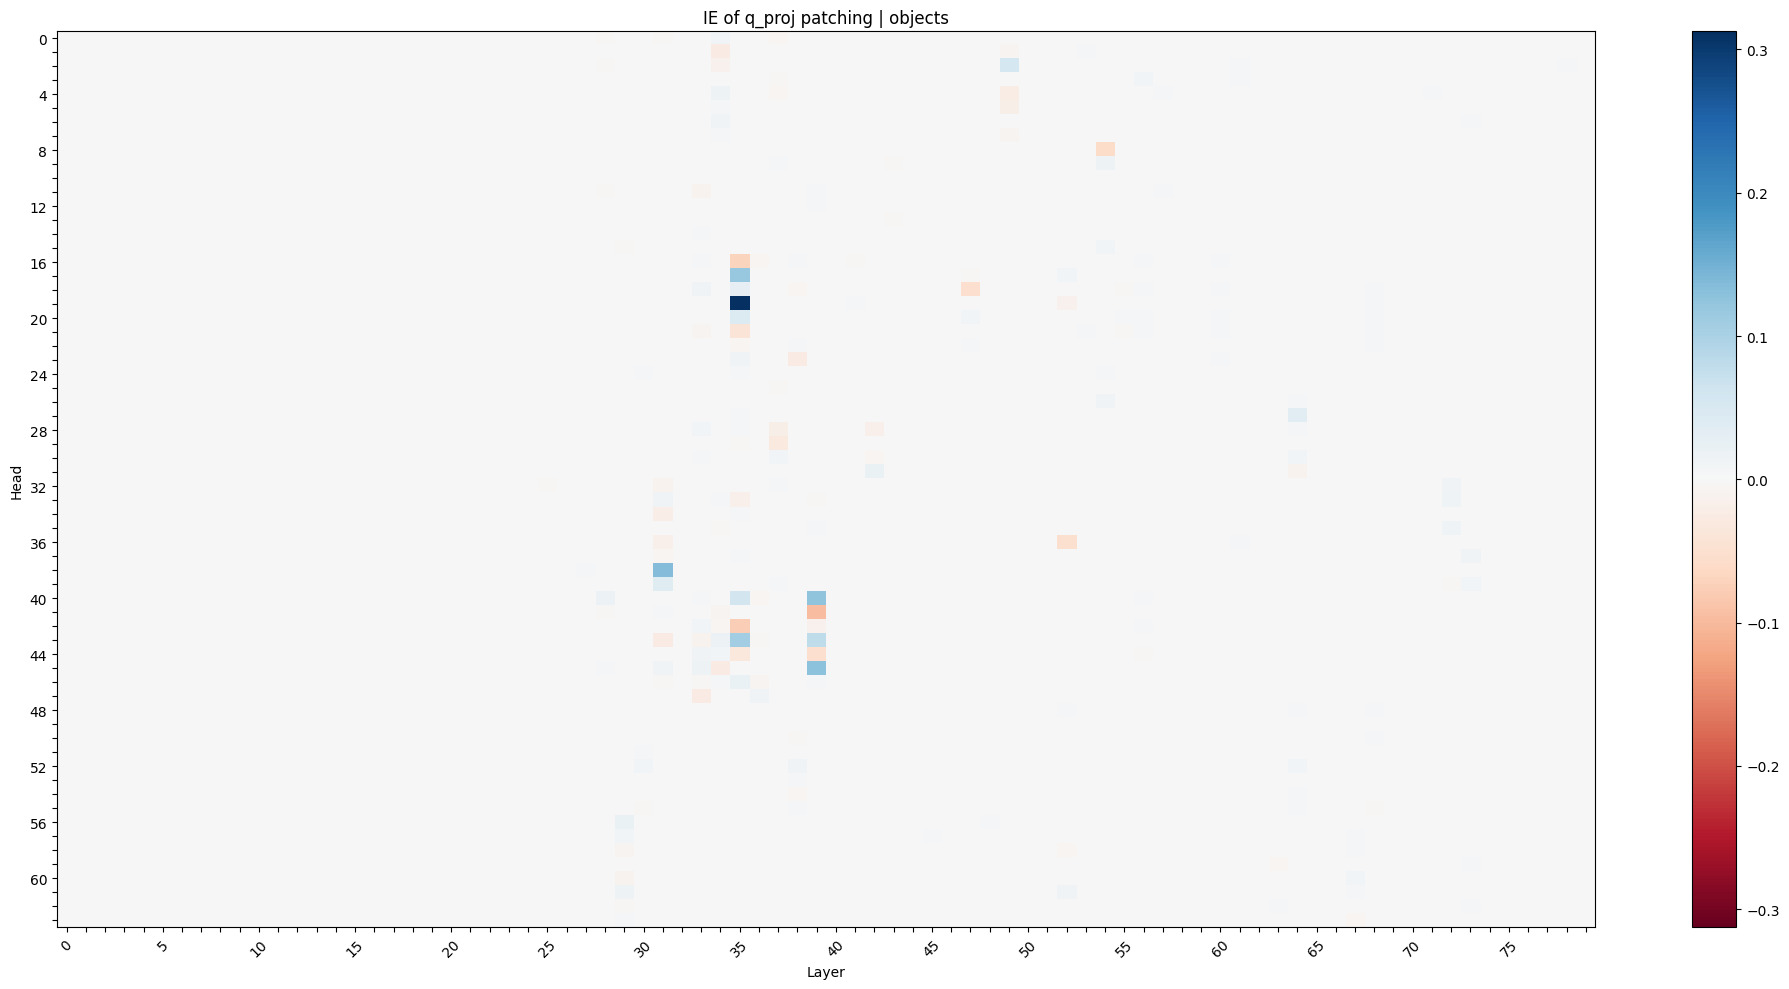

Layer 35, Head 19: 0.3127
Layer 31, Head 38: 0.1344
Layer 39, Head 45: 0.1280
Layer 39, Head 40: 0.1267
Layer 35, Head 17: 0.1187
Layer 35, Head 43: 0.1093
Layer 39, Head 43: 0.0782
Layer 35, Head 40: 0.0585
Layer 49, Head 2: 0.0557
Layer 35, Head 20: 0.0431
Layer 31, Head 39: 0.0375
Layer 64, Head 27: 0.0333
Layer 35, Head 18: 0.0262
Layer 29, Head 56: 0.0206
Layer 42, Head 31: 0.0205
2025-08-31 20:30:23 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7fbb49049f90>


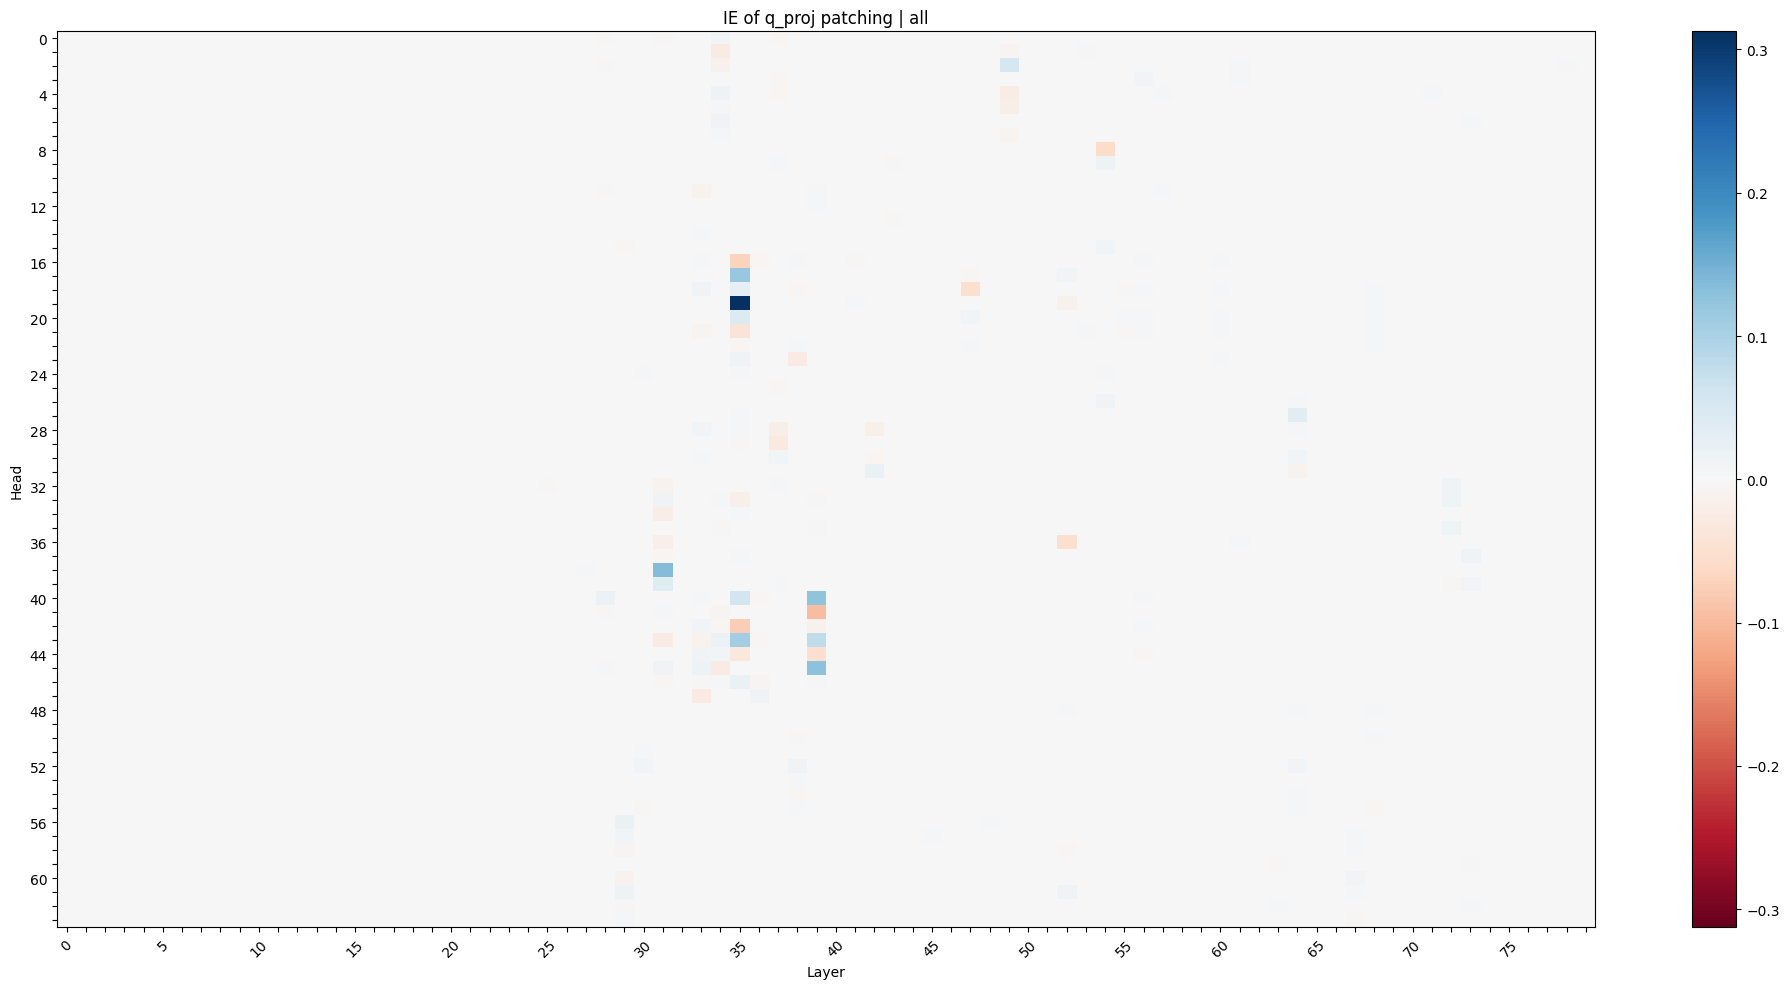

Layer 35, Head 19: 0.3127
Layer 31, Head 38: 0.1344
Layer 39, Head 45: 0.1280
Layer 39, Head 40: 0.1267
Layer 35, Head 17: 0.1187
Layer 35, Head 43: 0.1093
Layer 39, Head 43: 0.0782
Layer 35, Head 40: 0.0585
Layer 49, Head 2: 0.0557
Layer 35, Head 20: 0.0431
Layer 31, Head 39: 0.0375
Layer 64, Head 27: 0.0333
Layer 35, Head 18: 0.0262
Layer 29, Head 56: 0.0206
Layer 42, Head 31: 0.0205


In [34]:
from matplotlib import pyplot as plt

n_layer = len(layers)
n_heads = len(heads)

category_wise_heads = {}
for category, categorywise_result in results_copy.items():
    indirect_effects = torch.zeros((n_layer, n_heads), dtype=torch.float32)
    for layer_idx in range(n_layer):
        for head_idx in range(n_heads):
            indirect_effects[layer_idx, head_idx] = torch.mean(
                torch.tensor(
                    [
                        sample_result.head_effect(layer_idx, head_idx)
                        for sample_result in categorywise_result
                    ]
                )
            )

    plt.figure(figsize=(20, 10))
    scale = torch.max(torch.abs(indirect_effects))
    plt.imshow(
        indirect_effects.T.cpu().numpy(),
        cmap="RdBu",
        aspect="auto",
        vmin=-scale,
        vmax=scale,
    )
    plt.colorbar()
    # plt.title(f"score(target) - max(score(distractors)) | {token_idx.upper()} tokens of options")
    plt.title("IE of q_proj patching | " + category)
    plt.xlabel("Layer")
    plt.ylabel("Head")

    def get_ticks(ticks, skip=5):
        ret = []
        for i in ticks:
            if i % skip == 0:
                ret.append(str(i))
            else:
                ret.append("")
        return ret

    plt.xticks(
        ticks=range(n_layer),
        labels=get_ticks(range(n_layer)),
        rotation=45,
    )
    plt.yticks(
        ticks=range(n_head),
        labels=get_ticks(range(n_head), skip=4),
    )

    plt.tight_layout()
    plt.show()


    scores_per_head = []
    for layer_idx in layers:
        for head_idx in heads:
            scores_per_head.append(
                (layer_idx, head_idx, indirect_effects[layer_idx, head_idx].item())
            )

    scores_per_head = sorted(scores_per_head, key=lambda x: x[2], reverse=True)
    category_wise_heads[category] = scores_per_head
    for layer_idx, head_idx, score in scores_per_head[:15]:
        print(f"Layer {layer_idx}, Head {head_idx}: {score:.4f}")

with open("category_wise_heads.json", "w") as f:
    json.dump(category_wise_heads, f, indent=4)

#### Performing the Patch

In [ ]:
from src.tokens import prepare_input
from src.functional import get_module_nnsight

# HEADS = [
#     (33, 45),
#     (33, 18),
#     (34, 1),
#     (34, 6),
#     (34, 7),
#     (35, 19),
#     (39, 40),
#     (42, 30),
#     (47, 18),
#     (52, 58),
# ]

# HEADS = [
#     (layer_idx, head_idx)
#     for layer_idx, head_idx, score in category_wise_heads["all"][:50]
# ]

# HEADS = heads_selected

clean_tokenized = prepare_input(prompts=clean_sample.prompt(), tokenizer=mt)
patch_tokenized = prepare_input(prompts=patch_sample.prompt(), tokenizer=mt)

# category_wise_heads["all"][len(HEADS) - 1]

In [ ]:
from src.utils.typing import TokenizerOutput


@torch.inference_mode()
def cache_q_projections(
    mt: ModelandTokenizer,
    input: TokenizerOutput,
    query_locations: list[tuple[int, int, int]],  # (layer_idx, head_idx, query_idx)
    return_output: bool = False,
):
    layer_to_hq = {}
    for layer_idx, head_idx, query_idx in query_locations:
        if layer_idx not in layer_to_hq:
            layer_to_hq[layer_idx] = []
        layer_to_hq[layer_idx].append((head_idx, query_idx))

    q_projections = {}
    batch_size = input.input_ids.shape[0]
    seq_len = input.input_ids.shape[1]
    n_heads = mt.config.num_attention_heads
    head_dim = mt.n_embd // n_heads
    with mt.trace(input) as tracer:
        for layer_idx, query_locs in layer_to_hq.items():
            q_proj_name = mt.attn_module_name_format.format(layer_idx) + ".q_proj"
            q_proj_module = get_module_nnsight(mt, q_proj_name)
            q_proj_out = q_proj_module.output.view(
                batch_size, seq_len, n_heads, head_dim
            ).transpose(1, 2)
            for head_idx, query_idx in query_locs:
                q_projections[(layer_idx, head_idx, query_idx)] = (
                    q_proj_out[:, head_idx, query_idx, :].squeeze().save()
                )

        if return_output:
            output = mt.output.save()

    if return_output:
        return q_projections, output
    return q_projections

In [ ]:
query_indices = list(range(-3, 0))
query_locations = [
    (layer_idx, head_idx, query_idx)
    for layer_idx, head_idx in HEADS
    for query_idx in query_indices
]

cached_q_states = cache_q_projections(
    mt=mt,
    input=patch_tokenized,
    query_locations=query_locations,
)

# cached_q_states[(HEADS[0])].shape

In [ ]:
from src.attention import get_attention_matrices, visualize_attn_matrix
from src.functional import interpret_logits

clean_tokenized = prepare_input(prompts=clean_sample.prompt(), tokenizer=mt)

# attn_info = get_attention_matrices(
#     input=clean_tokenized,
#     mt=mt,
# )

# layer_idx, head_idx = 35, 19
# attn_matrix = attn_info.attention_matrices[layer_idx, head_idx].squeeze()
# visualize_attn_matrix(
#     attn_matrix=attn_matrix,
#     tokens=[mt.tokenizer.decode(t) for t in clean_tokenized.input_ids[0]],
#     q_index=-1,
# )

# interpret_logits(
#     tokenizer=mt,
#     logits=attn_info.logits,
#     interested_tokens=[clean_sample.obj_token_id, clean_sample.metadata["track_type_obj_token_id"]]
# )

attn_pattern = verify_head_patterns(
    prompt = clean_tokenized,
    options = clean_sample.options,
    pivot = clean_sample.subj,
    mt = mt,
    heads = HEADS,
    # heads = patching_heads,
    generate_full_answer=True,
)

attn_pattern["predictions"]

In [ ]:
from src.attention import get_attention_matrices, visualize_attn_matrix
from src.functional import patch_with_nnsight, patch_with_baukit, PatchSpec

q_proj_patches = []
for (layer_idx, head_idx, query_idx), q_proj in cached_q_states.items():
    q_proj_patches.append(
        PatchSpec(
            location=(mt.attn_module_name_format.format(layer_idx) + ".q_proj", head_idx, query_idx),
            patch=q_proj
        )
    )

# patched_attn_info = get_attention_matrices(
#     input=clean_tokenized,
#     mt=mt,
#     patches=q_proj_patches,
#     patch_interface=patch_with_baukit
# )

# layer_idx, head_idx = 35, 19
# patched_attn_matrix = patched_attn_info.attention_matrices[layer_idx, head_idx].squeeze()
# visualize_attn_matrix(
#     attn_matrix=patched_attn_matrix,
#     tokens=[mt.tokenizer.decode(t) for t in clean_tokenized.input_ids[0]],
#     q_index=-1,
# )

# interpret_logits(
#     tokenizer=mt,
#     logits=patched_attn_info.logits,
#     interested_tokens=[clean_sample.obj_token_id, clean_sample.metadata["track_type_obj_token_id"]]
# )

patched_attn_pattern = verify_head_patterns(
    prompt = clean_tokenized,
    options = clean_sample.options,
    pivot = clean_sample.subj,
    mt = mt,
    heads = HEADS,
    # heads = patching_heads,
    query_patches=q_proj_patches,
    # generate_full_answer=True,
)

patched_attn_pattern["predictions"]

### Search over layers and heads

In [ ]:
clean_sample.metadata

In [ ]:
from scripts.patching_within_task import SelectionQprojPatchResult

In [ ]:
from itertools import product
from src.functional import patch_with_baukit, interpret_logits
from src.selection.functional import cache_q_projections

all_heads = list(product(range(20, 30), range(mt.config.num_attention_heads)))
query_indices = {-3: -3, -2: -2, -1: -1}

clean_tokenized = prepare_input(prompts=clean_sample.prompt(), tokenizer=mt)
patch_tokenized = prepare_input(prompts=patch_sample.prompt(), tokenizer=mt)

interested_tokens = [
    patch_sample.ans_token_id,
    clean_sample.ans_token_id,
    clean_sample.metadata["track_type_obj_token_id"]
]


query_locations = [
    (layer_idx, head_idx, patch_query_idx)
    for layer_idx, head_idx in all_heads
    for patch_query_idx in query_indices.keys()
]

all_q_projections, patch_out = cache_q_projections(
    mt=mt,
    input=patch_tokenized,
    query_locations=query_locations,
    return_output=True,
)
logger.debug(len(all_q_projections))

patch_logits = patch_out.logits[:, -1, :].squeeze()
patch_precitions, patch_track = interpret_logits(
    tokenizer=mt,
    logits=patch_logits,
    interested_tokens=interested_tokens,
)

patch_precitions, patch_track

In [ ]:
clean_out = patch_with_baukit(
    mt=mt,
    inputs=clean_tokenized,
    patches=[],
)

base_logits = clean_out.logits[:, -1, :].squeeze()
base_predictions, base_track = interpret_logits(
    tokenizer=mt,
    logits=base_logits,
    interested_tokens=interested_tokens,
)
base_predictions, base_track

In [ ]:
from src.functional import PatchSpec
q_proj_patches = []
for (layer_idx, head_idx, patch_query_idx), q_proj in all_q_projections.items():
    q_proj_patches.append(
        PatchSpec(
            location=(
                mt.attn_module_name_format.format(layer_idx) + ".q_proj",
                head_idx,
                query_indices[patch_query_idx],
            ),
            patch=q_proj,
        )
    )

int_out = patch_with_baukit(
    mt = mt,
    inputs = clean_tokenized,
    patches = q_proj_patches,
)

logits = int_out.logits[:, -1, :].squeeze()

interpret_logits(
    tokenizer=mt,
    logits=logits,
    interested_tokens=interested_tokens
)

In [ ]:
len(all_q_projections)

In [ ]:
list(all_q_projections.keys())[:5]

In [ ]:
from tqdm.auto import tqdm
head_wise_patching_effects = {}

for (layer_idx, head_idx) in tqdm(all_heads):
    q_proj_patch = []
    for patch_tok_idx, clean_tok_idx in query_indices.items():
        q_proj_patch.append(
            PatchSpec(
                location=(
                    mt.attn_module_name_format.format(layer_idx) + ".q_proj", 
                    head_idx, 
                    query_indices[patch_tok_idx]
                ),
                patch=all_q_projections[(layer_idx, head_idx, patch_tok_idx)]
            )
        )
    out = patch_with_baukit(
        mt = mt,
        inputs = clean_tokenized,
        patches = q_proj_patch,
    )
    logits = out.logits[:, -1, :].squeeze()
    predictions, track = interpret_logits(
        tokenizer=mt,
        logits=logits,
        interested_tokens=interested_tokens
    )
    head_wise_patching_effects[(layer_idx, head_idx)] = track

In [ ]:
patching_results = SelectionQprojPatchResult(
    patch_sample=patch_sample,
    clean_sample=clean_sample,
    interested_tokens=interested_tokens,
    base_results=base_track,
    gold_results=patch_track,
    headwise_patching_effects=head_wise_patching_effects
)

In [ ]:
patching_results.head_effect(layer_idx=25, head_idx=19)

In [ ]:
headwise_scores = [
    (
        layer_idx,
        head_idx,
        patching_results.head_effect(layer_idx, head_idx)
    )
    for layer_idx, head_idx in head_wise_patching_effects.keys()
]

headwise_scores = sorted(headwise_scores, key=lambda x: x[2], reverse=True)
patching_heads = []
for layer_idx, head_idx, score in headwise_scores[:15]:
    print(f"Layer {layer_idx}, Head {head_idx}: {score:.4f}")
    patching_heads.append((layer_idx, head_idx))

In [ ]:
patching_results.patch_sample.metadata.pop("tokenized")
patching_results.clean_sample.metadata.pop("tokenized")

In [ ]:
patching_results.delist_patching_effects()


In [ ]:
with open("patching_results.json", "w") as f:
    json.dump(patching_results.to_dict(), f, indent=4)

In [ ]:
with open("patching_results.json", "r") as f:
    loaded_results = json.load(f)

loaded_results["headwise_patching_effects"] = {
    (int(layer_idx.split("_<>_")[0]), int(layer_idx.split("_<>_")[1])): effect
    for layer_idx, effect in loaded_results["headwise_patching_effects"].items()
}

In [ ]:
loaded_results["headwise_patching_effects"].keys()

In [ ]:
patching_results_loaded = SelectionQprojPatchResult.from_dict(loaded_results)
patching_results_loaded.head_effect(layer_idx=25, head_idx=19)

In [ ]:
mt.config.num_attention_heads

## Optimization to select heads to patch

In [33]:
from src.functional import free_gpu_cache
free_gpu_cache()

#################################################################################
train_limit = 512
# prompt_template_idx = 1
prompt_template_idx = 3
N_DISTRACTORS = 5
OPTION_STYLE = "single_line"
#################################################################################

train_set = []
while len(train_set) < train_limit:
    print(f"sample {len(train_set)+1}/{train_limit}")
    patch, clean = get_counterfactual_samples_within_task(
        mt=mt,
        task=select_task,
        filter_by_lm_prediction=True,
        prompt_template_idx=prompt_template_idx,
        option_style=OPTION_STYLE,
        distinct_options=True,
        patch_n_distractors=N_DISTRACTORS,
        clean_n_distractors=N_DISTRACTORS,
    )
    train_set.append((clean, patch))

sample 1/512
2025-09-09 17:29:21 src.selection.data INFO     clean_obj_idx=3 | ['Museum', 'Hickory', 'Violet', 'Toilet paper', 'Pencil', 'Mushroom']
type(task)=<class 'src.selection.data.SelectOneTask'>
2025-09-09 17:29:21 src.selection.data INFO     Options: Magnolia, Microphone, Factory, Train, Coffee maker, Razor.
Which among these objects mentioned above is a tree?
Answer:
2025-09-09 17:29:21 src.selection.data INFO     Bamboo | tree -> Magnolia | pred=['" Magn"[20918] (p=0.754, logit=21.625)', '" The"[578] (p=0.090, logit=19.500)', '" Among"[22395] (p=0.080, logit=19.375)', '" A"[362] (p=0.038, logit=18.625)', '" It"[1102] (p=0.005, logit=16.625)']
2025-09-09 17:29:21 src.selection.data INFO     Options: Museum, Hickory, Violet, Toilet paper, Pencil, Mushroom.
Which among these objects mentioned above is a bathroom item?
Answer:
2025-09-09 17:29:21 src.selection.data INFO     Shampoo | bathroom item -> Toilet paper | pred=['" Toilet"[82994] (p=0.836, logit=20.625)', '" Among"[2239

In [34]:
mt._model.zero_grad()
free_gpu_cache()
len(train_set)

512

In [ ]:
from src.selection.optimization import get_optimal_head_mask_optimized, get_optimal_head_mask_prev
import numpy as np

free_gpu_cache()

optimization_interface = {
    "legacy": get_optimal_head_mask_prev,
    "updated": get_optimal_head_mask_optimized,
}

#############################
intface = "legacy"
#############################

optimized_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "selection/test_localization_code",
    mt.name.split("/")[-1],
    f"{TASK_CLS.task_name}",
)

optimization_func = optimization_interface[intface]

indices_kwargs = {"query_indices": [-2, -1]}
if intface == "legacy":
    optimized_path = os.path.join(optimized_path, "legacy")
    # indices_kwargs["query_indices"] = [-3, -2, -1]
    indices_kwargs["query_indices"] = [-1]
elif intface == "updated":
    indices_kwargs["add_ques_pos_to_query_indices"] = True

optimal_mask, losses = optimization_func(
    mt=mt,
    train_set=train_set,
    learning_rate=1e-2,
    n_epochs=10,
    lamb=2e-2,
    batch_size=16,
    save_step=2,
    save_path=optimized_path,
    # black_list_heads=optimized_heads
    **indices_kwargs
)

os.makedirs(os.path.dirname(optimized_path), exist_ok=True)

np.savez_compressed(
    optimized_path,
    **dict(
        optimal_mask=optimal_mask.to(torch.float32).numpy(),
        losses=np.array(losses, dtype=np.float32),
    ),
    allow_pickle=True,
)

2025-09-09 17:33:30 src.selection.optimization DEBUG    Training with hparams: {'learning_rate': 0.01, 'n_epochs': 10, 'lamb': 0.08, 'batch_size': 16}
2025-09-09 17:33:30 src.selection.optimization INFO     Starting training...
2025-09-09 17:33:33 src.selection.optimization DEBUG    Epoch=1 | batch_idx=0 |>> -15.3750 + 13.5625 + 410.0000 = 408.0000
2025-09-09 17:33:40 src.selection.optimization DEBUG    Epoch=1 | batch_idx=1 |>> -15.2500 + 13.6250 + 404.0000 = 402.0000
2025-09-09 17:33:46 src.selection.optimization DEBUG    Epoch=1 | batch_idx=2 |>> -16.5000 + 13.6250 + 400.0000 = 398.0000
2025-09-09 17:33:53 src.selection.optimization DEBUG    Epoch=1 | batch_idx=3 |>> -15.9375 + 13.8125 + 394.0000 = 392.0000
2025-09-09 17:34:01 src.selection.optimization DEBUG    Epoch=1 | batch_idx=4 |>> -15.5000 + 13.3750 + 392.0000 = 390.0000
2025-09-09 17:34:08 src.selection.optimization DEBUG    Epoch=1 | batch_idx=5 |>> -15.1250 + 13.6875 + 386.0000 = 384.0000
2025-09-09 17:34:15 src.selection.

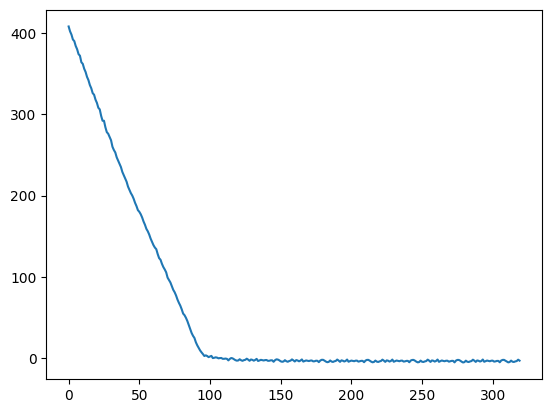

In [36]:
from matplotlib import pyplot as plt

optimized_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "selection/test_localization_code",
    mt.name.split("/")[-1],
    f"{TASK_CLS.task_name}",
    "legacy",
    "epoch_10.npz",
)

optimization_results = np.load(optimized_path, allow_pickle=True)
plt.plot(optimization_results["losses"])

37


(True, True)

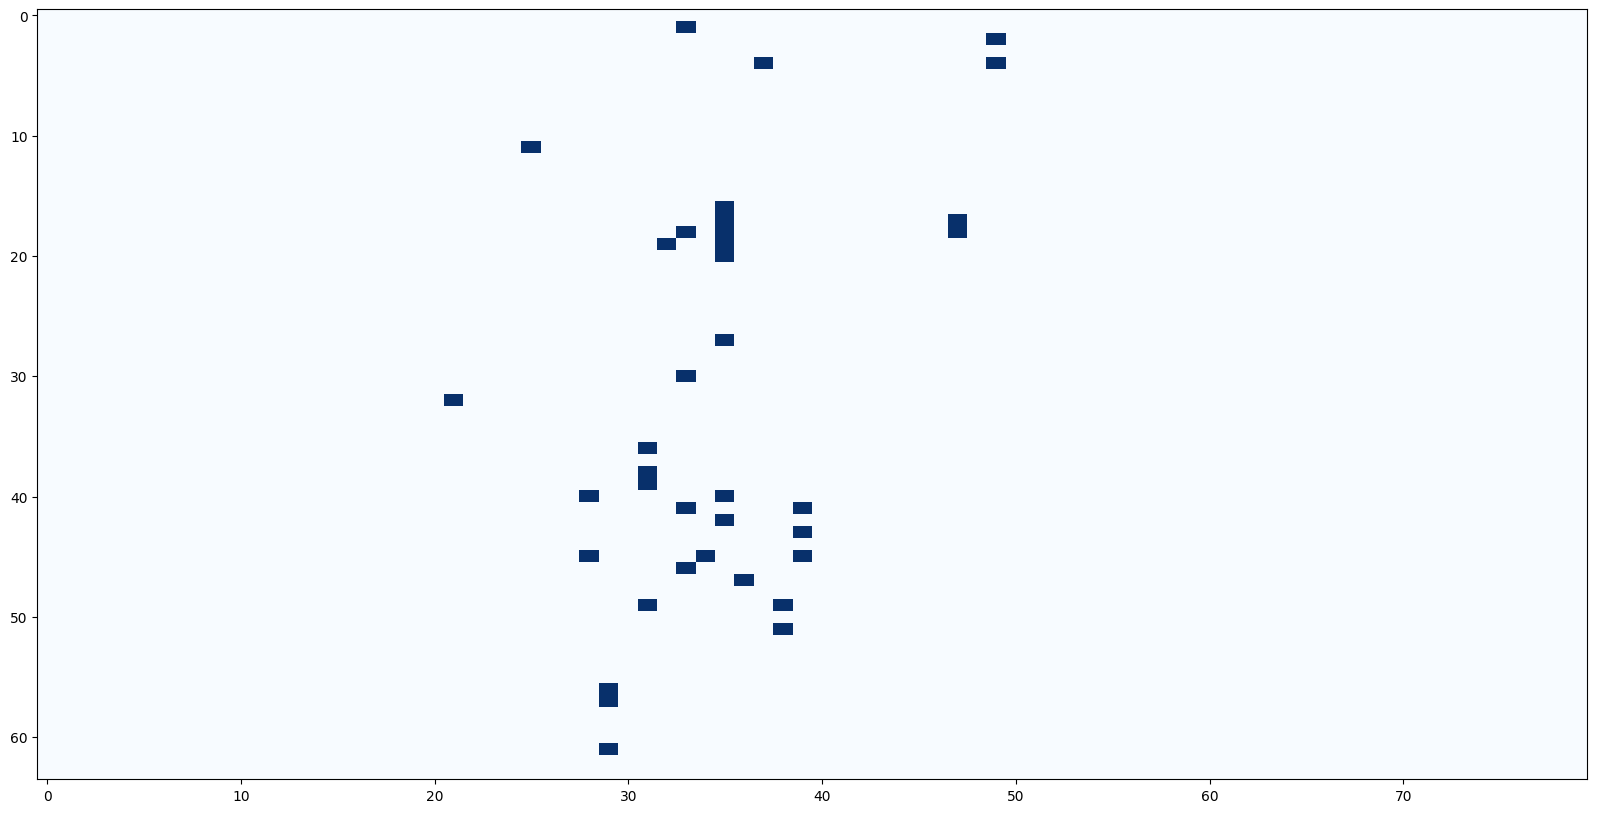

In [37]:
plt.figure(figsize=(20, 10))

optimal_head_mask = torch.tensor(optimization_results["optimal_mask"]).to(torch.float32)
optimal_head_mask[50:, :] = 0.0
# optimal_head_mask[75:, :] = 0.0
# optimal_head_mask[37:, :] = 0.0

plt.imshow(
    optimal_head_mask.T.numpy(),
    cmap="Blues",
    aspect="auto",
    vmin=0,
    vmax=1,
)

optimized_heads = torch.nonzero(optimal_head_mask > 0.5, as_tuple=False).to(dtype=torch.int).tolist()
optimized_heads = [
    (layer_idx, head_idx) for layer_idx, head_idx in optimized_heads
]
print(len(optimized_heads))

HEADS = optimized_heads

(35, 19) in HEADS, (35, 19) in optimized_heads

## Validation of the patching effect

In [39]:
from src.functional import free_gpu_cache
free_gpu_cache()
validation_set = []
validation_limit = 256

while len(validation_set) < validation_limit:
    print(f"sample {len(validation_set)+1} / {validation_limit}")
    patch, clean = get_counterfactual_samples_within_task(
        mt=mt,
        task=select_task,
        filter_by_lm_prediction=True,
        prompt_template_idx=prompt_template_idx,
        option_style=OPTION_STYLE,
        distinct_options=True,
        # n_distractors=N_DISTRACTORS,
        patch_n_distractors=N_DISTRACTORS,
        clean_n_distractors=N_DISTRACTORS
    )
    validation_set.append((clean, patch))

len(validation_set)

sample 1 / 256
2025-09-09 18:38:04 src.selection.data INFO     clean_obj_idx=5 | ['Accordion', 'Comb', 'Lily', 'Printer', 'Hat', 'Zebra']
type(task)=<class 'src.selection.data.SelectOneTask'>
2025-09-09 18:38:05 src.selection.data INFO     Options: Library, Violet, Eagle, Ruler, Lotion, Nightstand.
Which among these objects mentioned above is a flower?
Answer:
2025-09-09 18:38:05 src.selection.data INFO     Tulip | flower -> Violet | pred=['" Violet"[74574] (p=0.906, logit=22.375)', '" The"[578] (p=0.035, logit=19.125)', '" Among"[22395] (p=0.024, logit=18.750)', '" A"[362] (p=0.011, logit=18.000)', '" V"[650] (p=0.004, logit=16.875)']
2025-09-09 18:38:05 src.selection.data INFO     Options: Accordion, Comb, Lily, Printer, Hat, Zebra.
Which among these objects mentioned above is a animal?
Answer:
2025-09-09 18:38:05 src.selection.data INFO     Giraffe | animal -> Zebra | pred=['" Z"[1901] (p=0.840, logit=22.250)', '" A"[362] (p=0.054, logit=19.500)', '" The"[578] (p=0.047, logit=19.375

256

In [40]:
from typing import Any, Optional
from src.utils.typing import TokenizerOutput
from src.functional import get_module_nnsight, PatchSpec, patch_with_baukit
import baukit
import types
from src.hooking.llama_attention import LlamaAttentionPatcher
from src.attention import visualize_attn_matrix


@torch.inference_mode()
def cache_q_projections(
    mt: ModelandTokenizer,
    input: TokenizerOutput,
    heads: list[tuple[int, int]],  # (layer_idx, head_idx)
    token_indices: list[list[int]],
    return_output: bool = False,
    projection_signature: str = ".q_proj",
):
    batch_size = input.input_ids.shape[0]
    assert len(token_indices) == batch_size, f"{len(token_indices)=} != {batch_size=}"
    layer_to_head = {}
    for layer_idx, head_idx in heads:
        if layer_idx not in layer_to_head:
            layer_to_head[layer_idx] = []
        layer_to_head[layer_idx].append(head_idx)

    seq_len = input.input_ids.shape[1]
    n_heads = mt.config.num_attention_heads
    # head_dim = mt.n_embd // n_heads
    head_dim = get_module_nnsight(
        mt._model, mt.attn_module_name_format.format(0)
    ).head_dim
    group_size = n_heads // mt.config.num_key_value_heads
    q_module_projections_per_layer = {}
    with mt.trace(input) as tracer:  # noqa
        for layer_idx, head_indices in layer_to_head.items():
            q_proj_name = (
                mt.attn_module_name_format.format(layer_idx) + projection_signature
            )
            q_proj_module = get_module_nnsight(mt, q_proj_name)
            q_module_projections_per_layer[q_proj_name] = q_proj_module.output.save()

        if return_output:
            output = mt.output.save()

    q_projections = [{} for _ in range(batch_size)]
    for layer_idx, head_indices in layer_to_head.items():
        q_proj_name = (
            mt.attn_module_name_format.format(layer_idx) + projection_signature
        )
        # print(q_proj_name)
        q_proj_out = (
            q_module_projections_per_layer[q_proj_name]
            .view(batch_size, seq_len, -1, head_dim)
            .transpose(1, 2)
        )
        if projection_signature in [".k_proj", ".v_proj"] and group_size != 1:
            q_proj_out = repeat_kv(q_proj_out, n_rep=group_size)
        # print(q_proj_out.shape, q_proj_out.norm())
        for prompt_idx in range(batch_size):
            for head_idx in head_indices:
                for token_idx in token_indices[prompt_idx]:
                    q_projections[prompt_idx][(layer_idx, head_idx, token_idx)] = (
                        q_proj_out[prompt_idx, head_idx, token_idx]
                    )

    if return_output:
        return q_projections, output
    return q_projections


def locate_with_delim(prompt, option):
    st = prompt.index(option)
    return prompt[st : st + len(option) + 1]


@torch.no_grad()
def validate_q_proj_ie_on_sample_pair(
    mt: ModelandTokenizer,
    clean_sample: SelectionSample,
    patch_sample: SelectionSample,
    heads: list[tuple[int, int]],
    query_indices: dict[int, int] = {-1: -1},  # patch_idx -> clean_idx
    verify_head_behavior_on: Optional[int] = None,
    ablate_possible_ans_info_from_options: bool = False,
    amplification_scale: float = 1.0,
    must_track_tokens: list[int] = [],
    patch_args: dict[str, Any] = {},
):
    clean_tokenized = prepare_input(prompts=clean_sample.prompt(), tokenizer=mt)
    patch_tokenized = prepare_input(prompts=patch_sample.prompt(), tokenizer=mt)
    if patch_args.get("batch_size", 1) > 1:
        patch_samples = []
        task = patch_args["task"]
        logger.debug(f"Sampling {patch_args.get('batch_size', 1)} patch samples...")
        while len(patch_samples) < patch_args.get("batch_size", 1):
            obj_idx = len(patch_samples) % len(patch_sample.options)
            if patch_args["distinct_options"] is True:
                sample = task.get_random_sample(
                    mt=mt,
                    category=patch_sample.category,
                    prompt_template_idx=patch_args["prompt_template_idx"],
                    option_style=patch_args["option_style"],
                    filter_by_lm_prediction=True,
                    exclude_objs=[clean_sample.obj, patch_sample.obj],
                    n_distractors=patch_args["n_distractors"],
                    obj_idx=obj_idx,
                )
            else:
                sample = copy.deepcopy(patch_sample)
                sample.options[obj_idx], sample.options[sample.obj_idx] = (
                    sample.options[sample.obj_idx],
                    sample.options[obj_idx],
                )
                sample.obj_idx = obj_idx
                # random.shuffle(sample.options)
            patch_samples.append(sample)
        patch_tokenized_batch = prepare_input(
            prompts=[sample.prompt() for sample in patch_samples], tokenizer=mt
        )
        logger.debug(f"{patch_tokenized_batch.input_ids.shape}")

    if verify_head_behavior_on is not None:
        logger.info("Verifying head behavior...")

        logger.info(f"Clean Sample >> Ans: {clean_sample.obj}")
        clean_attn_pattern = verify_head_patterns(  # noqa
            prompt=clean_sample.prompt(),
            tokenized_prompt=clean_tokenized,
            options=(
                [
                    locate_with_delim(clean_sample.prompt(), opt)
                    for opt in clean_sample.options
                ]
                if ablate_possible_ans_info_from_options
                else clean_sample.options
            ),
            pivot=clean_sample.subj,
            mt=mt,
            heads=heads,
            generate_full_answer=True,
            query_index=verify_head_behavior_on,
            ablate_possible_ans_info_from_options=ablate_possible_ans_info_from_options,
        )

        logger.info(f"Patch Sample >> Ans: {patch_sample.obj}")
        patch_attn_pattern = verify_head_patterns(  # noqa
            prompt=patch_sample.prompt(),
            tokenized_prompt=patch_tokenized,
            options=(
                [
                    locate_with_delim(patch_sample.prompt(), opt)
                    for opt in patch_sample.options
                ]
                if ablate_possible_ans_info_from_options
                else patch_sample.options
            ),
            pivot=patch_sample.subj,
            mt=mt,
            heads=heads,
            generate_full_answer=True,
            query_index=verify_head_behavior_on,
            ablate_possible_ans_info_from_options=ablate_possible_ans_info_from_options,
        )

    logger.info(f"Caching the query states for the {len(heads)} heads")

    cached_q_states, patch_output = cache_q_projections(
        mt=mt,
        input=patch_tokenized,
        heads=heads,
        token_indices=[list(query_indices.keys())],
        return_output=True,
    )
    if patch_args.get("batch_size", 1) > 1:
        cached_q_states = cache_q_projections(
            mt=mt,
            input=patch_tokenized_batch,
            heads=heads,
            token_indices=[list(query_indices.keys())]
            * patch_args.get("batch_size", 1),
            return_output=False,
        )
        mean_q_states = {}
        for prompt_idx in range(patch_args.get("batch_size", 1)):
            for key, value in cached_q_states[prompt_idx].items():
                if key not in mean_q_states:
                    mean_q_states[key] = []
                mean_q_states[key].append(value)
        for key, value in mean_q_states.items():
            mean_q_states[key] = torch.mean(torch.stack(value), dim=0)
        cached_q_states = [mean_q_states]

    q_proj_patches = []
    for (layer_idx, head_idx, patch_query_idx), q_proj in cached_q_states[0].items():
        q_proj_patches.append(
            PatchSpec(
                location=(
                    mt.attn_module_name_format.format(layer_idx) + ".q_proj",
                    head_idx,
                    query_indices[patch_query_idx],
                ),
                patch=q_proj,
            )
        )

    patch_logits = patch_output.logits[:, -1, :].squeeze()
    patch_predictions = interpret_logits(
        tokenizer=mt,
        logits=patch_logits,
    )
    logger.info(f"patch_prediction={[str(pred) for pred in patch_predictions]}")

    # interested_tokens = [
    #     patch_sample.ans_token_id,
    #     clean_sample.ans_token_id,
    #     clean_sample.metadata["track_type_obj_token_id"],
    # ]
    interested_tokens = clean_sample.options
    interested_tokens = [
        get_first_token_id(name=opt, tokenizer=mt.tokenizer, prefix=" ")
        for opt in interested_tokens
    ]
    # interested_tokens += [patch_sample.ans_token_id]
    # interested_tokens = list(set(interested_tokens))  # remove duplicates #! don't need to, made sure during sampling

    logger.info("clean run")
    clean_output = patch_with_baukit(
        mt=mt,
        inputs=clean_tokenized,
        patches=[],
    )
    clean_logits = clean_output.logits[:, -1, :].squeeze()
    clean_predictions, clean_track = interpret_logits(
        tokenizer=mt,
        logits=clean_logits,
        interested_tokens=interested_tokens + must_track_tokens,
    )
    logger.info(f"clean_prediction={[str(pred) for pred in clean_predictions]}")
    logger.info(f"clean_track={clean_track}")

    logger.info("patching the q_proj states")

    if verify_head_behavior_on is not None and amplification_scale == 1.0:
        int_attn_pattern = verify_head_patterns(
            prompt=clean_sample.prompt(),
            tokenized_prompt=clean_tokenized,
            options=(
                [
                    locate_with_delim(clean_sample.prompt(), opt)
                    for opt in clean_sample.options
                ]
                if ablate_possible_ans_info_from_options
                else clean_sample.options   
            ),
            pivot=clean_sample.subj,
            mt=mt,
            heads=heads,
            query_patches=q_proj_patches,
            generate_full_answer=False,
            query_index=verify_head_behavior_on,
            ablate_possible_ans_info_from_options=ablate_possible_ans_info_from_options,
        )
        int_logits = int_attn_pattern["logits"].squeeze()

    else:
        default_attn_implementation = mt.config._attn_implementation
        if amplification_scale != 1.0:
            mt.reset_forward()
            mt.set_attn_implementation("sdpa")

            layers_to_heads = {}
            for layer_idx, head_idx in heads:
                if layer_idx not in layers_to_heads:
                    layers_to_heads[layer_idx] = []
                layers_to_heads[layer_idx].append(head_idx)

            layers_to_q_patches = {}
            for (
                layer_idx,
                head_idx,
                patch_query_idx,
            ), patch in cached_q_states[0].items():
                if layer_idx not in layers_to_q_patches:
                    layers_to_q_patches[layer_idx] = []
                layers_to_q_patches[layer_idx].append(
                    (head_idx, query_indices[patch_query_idx], patch)
                )

            attention_patterns = {}
            head_contributions = {}
            for layer_idx, head_indices in layers_to_heads.items():
                attn_block_name = mt.attn_module_name_format.format(layer_idx)
                attn_block = baukit.get_module(mt._model, attn_block_name)

                attention_patterns[layer_idx] = {}
                head_contributions[layer_idx] = {}

                attn_block.forward = types.MethodType(
                    LlamaAttentionPatcher(
                        block_name=attn_block_name,
                        save_attn_for=head_indices,
                        store_attn_matrices=attention_patterns[layer_idx],
                        store_head_contributions=head_contributions[layer_idx],
                        query_patches=layers_to_q_patches[layer_idx],
                        amplify_contributions=[
                            (head_idx, q_idx, amplification_scale)
                            for head_idx in head_indices
                            for q_idx in query_indices.values()
                        ],
                        # value_weighted=True,
                    ),
                    attn_block,
                )
            patches = []  # already handled by hooking the default forward pass

        else:
            patches = q_proj_patches

        if ablate_possible_ans_info_from_options:
            patches.extend(
                get_patches_to_verify_independent_enrichment(
                    prompt=clean_sample.prompt(),
                    options=clean_sample.options,
                    pivot=clean_sample.subj,
                    mt=mt,
                    tokenized_prompt=clean_tokenized,
                )
            )

        int_out = patch_with_baukit(
            mt=mt,
            inputs=clean_tokenized,
            patches=patches,
        )
        int_logits = int_out.logits[:, -1, :].squeeze()

        if amplification_scale != 1.0:
            mt.reset_forward()
            mt.set_attn_implementation(default_attn_implementation)

            if verify_head_behavior_on is not None:
                attn_matrix = []
                for layer_idx in attention_patterns:
                    for head_idx in attention_patterns[layer_idx]:
                        attn_matrix.append(
                            attention_patterns[layer_idx][head_idx].cpu()
                        )

                attn_matrix = torch.stack(attn_matrix).squeeze()
                if attn_matrix.dim() == 3:
                    attn_matrix = attn_matrix.mean(dim=0)

                visualize_attn_matrix(
                    attn_matrix=attn_matrix,
                    tokens=[
                        mt.tokenizer.decode(t) for t in clean_tokenized["input_ids"][0]
                    ],
                )

    int_predictions, int_track = interpret_logits(
        tokenizer=mt,
        logits=int_logits,
        interested_tokens=interested_tokens + must_track_tokens,
    )
    logger.info(f"int_prediction={[str(pred) for pred in int_predictions]}")
    logger.info(f"int_track={int_track}")

    return {
        "clean_sample": clean_sample,
        "patch_sample": patch_sample,
        "clean_predictions": clean_predictions,
        "patch_predictions": patch_predictions,
        "int_predictions": int_predictions,
        "clean_track": clean_track,
        "int_track": int_track,
    }

In [41]:
len(optimized_heads)

37

In [42]:
# from src.selection.optimization import validate_q_proj_ie_on_sample_pair

clean, patch = copy.deepcopy(validation_set[15])
# clean.default_option_style="numbered"
# patch.default_option_style="numbered"
# clean, patch = train_set[18]

# clean, patch = copy.deepcopy(clean_sample), copy.deepcopy(patch_sample)

# failed_case = failed_cases[27]
# clean = failed_case["clean_sample"]
# patch = failed_case["patch_sample"]

print(clean.prompt(), ">>", clean.obj)
print(patch.prompt(), ">>", patch.obj)

mt.set_attn_implementation("eager")
mt.reset_forward()

validation_result = validate_q_proj_ie_on_sample_pair(
    mt=mt,
    clean_sample=clean,
    patch_sample=patch,
    heads=optimized_heads,
    # heads=sorted(qwen_32_heads, key=lambda x: (x[0], x[1])),
    # heads=sorted(heads_attn_behavior, key=lambda x: (x[0], x[1])),
    # heads=[(35, 19)],
    query_indices={
        patch.metadata["ques_pos"]: clean.metadata["ques_pos"],
        -2: -2,
        -1: -1,
    },
    verify_head_behavior_on=clean.metadata["ques_pos"]
    # verify_head_behavior_on=-2,
    # ablate_possible_ans_info_from_options=True,
    # amplification_scale=2.0
    # patch_args={
    #     "batch_size": N_DISTRACTORS + 1,
    #     "task": select_task,
    #     "prompt_template_idx": prompt_template_idx,
    #     "option_style": patch.default_option_style,
    #     "distinct_options": False,
    #     "n_distractors": N_DISTRACTORS,
    # },
)

clean_obj = clean.ans_token_id
target_obj = clean.metadata["track_type_obj_token_id"]

logger.debug(f"clean obj: {mt.tokenizer.decode(clean_obj)}")
logger.debug(f"target obj: {mt.tokenizer.decode(target_obj)}")

before_intervention = {
    "clean_rank": validation_result["clean_track"][clean_obj][0],
    "clean_logit": validation_result["clean_track"][clean_obj][1].logit,
    "target_rank": validation_result["clean_track"][target_obj][0],
    "target_logit": validation_result["clean_track"][target_obj][1].logit,
}

after_intervention = {
    "clean_rank": validation_result["int_track"][clean_obj][0],
    "clean_logit": validation_result["int_track"][clean_obj][1].logit,
    "target_rank": validation_result["int_track"][target_obj][0],
    "target_logit": validation_result["int_track"][target_obj][1].logit,
}

clean_rank_delta = after_intervention["clean_rank"] - before_intervention["clean_rank"]
target_rank_delta = (
    after_intervention["target_rank"] - before_intervention["target_rank"]
)
logger.info(
    f"Clean Prediction Rank Change: {before_intervention['clean_rank']} -> {after_intervention['clean_rank']} | Delta: {clean_rank_delta} "
)
logger.info(
    f"Target Prediction Rank Change: {before_intervention['target_rank']} -> {after_intervention['target_rank']} | Delta: {target_rank_delta} "
)

clean_logit_delta = (
    after_intervention["clean_logit"] - before_intervention["clean_logit"]
)
target_logit_delta = (
    after_intervention["target_logit"] - before_intervention["target_logit"]
)
logger.info(
    f"Clean Prediction Logit Change: {before_intervention['clean_logit']:.4f} -> {after_intervention['clean_logit']:.4f} | Delta: {clean_logit_delta:.4f} "
)
logger.info(
    f"Target Prediction Logit Change: {before_intervention['target_logit']:.4f} -> {after_intervention['target_logit']:.4f} | Delta: {target_logit_delta:.4f} "
)

Options: Pressure cooker, Router, Bracelet, Dolphin, Calculator, Flute.
Which among these objects mentioned above is a jewelry?
Answer: >> Bracelet
Options: Anklet, Marker, Lotion, Trumpet, Theater, Bench.
Which among these objects mentioned above is a music instrument?
Answer: >> Trumpet
2025-09-09 18:40:31 __main__ INFO     Verifying head behavior...
2025-09-09 18:40:31 __main__ INFO     Clean Sample >> Ans: Bracelet


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


2025-09-09 18:40:35 src.selection.functional DEBUG    Generated full answer: " Bracelet. A bracelet is a type of jewelry that is worn around the wrist. It is a decorative item and can be made from various materials such"
2025-09-09 18:40:35 src.selection.functional DEBUG    Predictions: ['" Brace"[70306] (p=0.781, logit=22.125)', '" A"[362] (p=0.073, logit=19.750)', '" The"[578] (p=0.064, logit=19.625)', '" Among"[22395] (p=0.039, logit=19.125)', '" b"[293] (p=0.009, logit=17.625)']
2025-09-09 18:40:35 src.selection.functional INFO     Combined attention matrix for all heads


2025-09-09 18:40:36 __main__ INFO     Patch Sample >> Ans: Trumpet


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


2025-09-09 18:40:40 src.selection.functional DEBUG    Generated full answer: " Trumpet. Trumpet is a musical instrument. It is a brass instrument commonly used in classical and jazz music. The other options are not musical instruments"
2025-09-09 18:40:41 src.selection.functional DEBUG    Predictions: ['" Trump"[3420] (p=0.824, logit=22.250)', '" The"[578] (p=0.087, logit=20.000)', '" A"[362] (p=0.032, logit=19.000)', '" Among"[22395] (p=0.025, logit=18.750)', '" It"[1102] (p=0.004, logit=16.875)']
2025-09-09 18:40:41 src.selection.functional INFO     Combined attention matrix for all heads


2025-09-09 18:40:42 __main__ INFO     Caching the query states for the 37 heads
2025-09-09 18:40:42 __main__ INFO     patch_prediction=['" Trump"[3420] (p=0.824, logit=22.250)', '" The"[578] (p=0.087, logit=20.000)', '" A"[362] (p=0.032, logit=19.000)', '" Among"[22395] (p=0.025, logit=18.750)', '" It"[1102] (p=0.004, logit=16.875)']
2025-09-09 18:40:42 __main__ INFO     clean run
2025-09-09 18:40:42 __main__ INFO     clean_prediction=['" Brace"[70306] (p=0.781, logit=22.125)', '" A"[362] (p=0.073, logit=19.750)', '" The"[578] (p=0.064, logit=19.625)', '" Among"[22395] (p=0.039, logit=19.125)', '" b"[293] (p=0.009, logit=17.625)']
2025-09-09 18:40:42 __main__ INFO     clean_track=OrderedDict([(70306, (1, PredictedToken(token=' Brace', prob=0.78125, logit=22.125, token_id=70306, metadata=None))), (96096, (95, PredictedToken(token=' Dolphin', prob=1.895427703857422e-05, logit=11.5, token_id=96096, metadata=None))), (3061, (131, PredictedToken(token=' Fl', prob=1.0132789611816406e-05, log

2025-09-09 18:40:43 __main__ INFO     int_prediction=['" Fl"[3061] (p=0.672, logit=20.875)', '" The"[578] (p=0.132, logit=19.250)', '" Among"[22395] (p=0.071, logit=18.625)', '" A"[362] (p=0.049, logit=18.250)', '" It"[1102] (p=0.012, logit=16.875)']
2025-09-09 18:40:43 __main__ INFO     int_track=OrderedDict([(3061, (1, PredictedToken(token=' Fl', prob=0.671875, logit=20.875, token_id=3061, metadata=None))), (70306, (7, PredictedToken(token=' Brace', prob=0.00958251953125, logit=16.625, token_id=70306, metadata=None))), (40090, (53, PredictedToken(token=' Pressure', prob=0.000164031982421875, logit=12.5625, token_id=40090, metadata=None))), (96096, (87, PredictedToken(token=' Dolphin', prob=5.340576171875e-05, logit=11.4375, token_id=96096, metadata=None))), (37128, (148, PredictedToken(token=' Calculator', prob=1.8477439880371094e-05, logit=10.375, token_id=37128, metadata=None))), (10777, (348, PredictedToken(token=' Router', prob=3.203749656677246e-06, logit=8.625, token_id=10777, 

In [91]:
print(clean_sample.options)
print(clean_sample.prompt())

['Cauliflower', 'Ukulele', 'Ring', 'Cherry', 'Pen', 'Hat']
Options: Cauliflower, Ukulele, Ring, Cherry, Pen, Hat.
Which among these objects mentioned above is a music instrument?
Answer:


In [43]:
# from src.selection.functional import cache_q_projections, verify_head_patterns
# from typing import Literal
# from src.functional import PatchSpec, interpret_logits
# from src.hooking.llama_attention import LlamaAttentionPatcher
# import baukit
# import types


# def set_attn_implementation(mt, attn_implementation: Literal["sdpa", "eager"]):
#     mt.config._attn_implementation = attn_implementation
#     for layer_idx in range(mt.config.num_hidden_layers):
#         attn_block_name = mt.attn_module_name_format.format(layer_idx)
#         attn_block = baukit.get_module(mt._model, attn_block_name)
#         attn_block.config._attn_implementation = attn_implementation


# ##########################################################
# query_indices = [-3, -2, -1]
# heads = optimized_heads
# ##########################################################

# mt.reset_forward()
# set_attn_implementation(mt, "eager")

# clean_sample = failed_case["clean_sample"]
# patch_sample = failed_case["patch_sample"]

# clean_tokenized = prepare_input(prompts=clean_sample.prompt(), tokenizer=mt)
# patch_tokenized = prepare_input(prompts=patch_sample.prompt(), tokenizer=mt)

# verify_head_patterns(
#     prompt=patch_sample.prompt(),
#     tokenized_prompt=patch_tokenized,
#     pivot=patch_sample.subj,
#     options=patch_sample.options,
#     mt=mt,
#     heads=heads,
#     query_index=-1,
# )

# verify_head_patterns(
#     prompt=clean_sample.prompt(),
#     tokenized_prompt=clean_tokenized,
#     pivot=clean_sample.subj,
#     options=clean_sample.options,
#     mt=mt,
#     heads=heads,
#     query_index=-1,
# )

# query_locations = [
#     (layer_idx, head_idx, query_idx)
#     for layer_idx, head_idx in heads
#     for query_idx in query_indices
# ]

# cached_q_states, patch_output = cache_q_projections(
#     mt=mt,
#     input=patch_tokenized,
#     query_locations=query_locations,
#     return_output=True,
# )
# q_proj_patches = []
# for (layer_idx, head_idx, query_idx), q_proj in cached_q_states.items():
#     q_proj_patches.append(
#         PatchSpec(
#             location=(
#                 mt.attn_module_name_format.format(layer_idx) + ".q_proj",
#                 head_idx,
#                 query_idx,
#             ),
#             patch=q_proj,
#         )
#     )

# patch_logits = patch_output.logits[:, -1, :].squeeze()
# patch_predictions = interpret_logits(
#     tokenizer=mt,
#     logits=patch_logits,
# )
# logger.info(f"patch_prediction={[str(pred) for pred in patch_predictions]}")


# mt.reset_forward()
# set_attn_implementation(mt, "sdpa")

# layers_to_heads = {}
# for layer_idx, head_idx in heads:
#     if layer_idx not in layers_to_heads:
#         layers_to_heads[layer_idx] = []
#     layers_to_heads[layer_idx].append(head_idx)

# layers_to_q_patches = {}
# for (layer_idx, head_idx, query_idx), patch in cached_q_states.items():
#     if layer_idx not in layers_to_q_patches:
#         layers_to_q_patches[layer_idx] = []
#     layers_to_q_patches[layer_idx].append((head_idx, query_idx, patch))

# attention_patterns = {}
# head_contributions = {}
# for layer_idx, head_indices in layers_to_heads.items():
#     attn_block_name = mt.attn_module_name_format.format(layer_idx)
#     attn_block = baukit.get_module(mt._model, attn_block_name)

#     attention_patterns[layer_idx] = {}
#     head_contributions[layer_idx] = {}

#     attn_block.forward = types.MethodType(
#         LlamaAttentionPatcher(
#             block_name=attn_block_name,
#             save_attn_for=head_indices,
#             store_attn_matrices=attention_patterns[layer_idx],
#             store_head_contributions=head_contributions[layer_idx],
#             query_patches=layers_to_q_patches[layer_idx],
#             amplify_contributions=[
#                 (head_idx, q_idx, 2.0)
#                 for head_idx in head_indices
#                 for q_idx in query_indices
#             ],
#             # value_weighted=True,
#         ),
#         attn_block,
#     )


# output = mt._model(**clean_tokenized)
# int_logits = output.logits[:, -1, :].squeeze()
# int_pred = interpret_logits(
#     tokenizer=mt,
#     logits=int_logits,
# )

# logger.info(f"int_prediction={[str(pred) for pred in int_pred]}")

# mt.reset_forward()
# set_attn_implementation(mt, "eager")

In [44]:
# from src.selection.functional import visualize_attn_matrix

# attn_matrix = []
# for layer_idx in attention_patterns:
#     for head_idx in attention_patterns[layer_idx]:
#         attn_matrix.append(attention_patterns[layer_idx][head_idx].cpu())
# attn_matrix = torch.stack(attn_matrix).squeeze().mean(dim=0)

# visualize_attn_matrix(
#     attn_matrix = attn_matrix,
#     tokens = [mt.tokenizer.decode(t) for t in clean_tokenized["input_ids"][0]]
# )



In [45]:
from tqdm.auto import tqdm
from src.selection.optimization import validate_q_proj_ie_on_sample_pair

validation_results = []
for clean_sample, patch_sample in tqdm(validation_set):
    result = validate_q_proj_ie_on_sample_pair(
        mt=mt,
        clean_sample=clean_sample,
        patch_sample=patch_sample,
        heads=optimized_heads,
        # heads=backup_heads,
        # heads=optimized_heads + backup_heads,
        # heads = overlapping_heads,
        query_indices={-2: -2, -1: -1},
        add_ques_pos_to_query_indices=True,
        verify_head_behavior_on=None,
        # amplification_scale=1.5
    )
    validation_results.append(result)
    print("=" * 80)

  0%|          | 0/256 [00:00<?, ?it/s]

2025-09-09 18:40:56 src.selection.optimization INFO     Caching the query states for the 37 heads
2025-09-09 18:40:56 src.selection.optimization INFO     patch_prediction=['" Violet"[74574] (p=0.906, logit=22.375)', '" The"[578] (p=0.035, logit=19.125)', '" Among"[22395] (p=0.024, logit=18.750)', '" A"[362] (p=0.011, logit=18.000)', '" V"[650] (p=0.004, logit=16.875)']
2025-09-09 18:40:56 src.selection.optimization INFO     clean run
2025-09-09 18:40:56 src.selection.optimization INFO     clean_prediction=['" Z"[1901] (p=0.840, logit=22.250)', '" A"[362] (p=0.054, logit=19.500)', '" The"[578] (p=0.047, logit=19.375)', '" Among"[22395] (p=0.020, logit=18.500)', '" z"[1167] (p=0.011, logit=17.875)']
2025-09-09 18:40:56 src.selection.optimization INFO     clean_track=OrderedDict([(1901, (1, PredictedToken(token=' Z', prob=0.83984375, logit=22.25, token_id=1901, metadata=None))), (11683, (18, PredictedToken(token=' Acc', prob=0.00063323974609375, logit=15.0625, token_id=11683, metadata=Non

In [46]:
before_intervention = []
after_intervention = []

for intervention_result in validation_results:
    clean_sample = intervention_result["clean_sample"]
    patch_sample = intervention_result["patch_sample"]

    clean_obj = clean_sample.ans_token_id
    target_obj = clean_sample.metadata["track_type_obj_token_id"]

    before_intervention.append({
        "clean_rank": intervention_result["clean_track"][clean_obj][0],
        "clean_logit": intervention_result["clean_track"][clean_obj][1].logit,
        "target_rank": intervention_result["clean_track"][target_obj][0],
        "target_logit": intervention_result["clean_track"][target_obj][1].logit,
    })

    after_intervention.append({
        "clean_rank": intervention_result["int_track"][clean_obj][0],
        "clean_logit": intervention_result["int_track"][clean_obj][1].logit,
        "target_rank": intervention_result["int_track"][target_obj][0],
        "target_logit": intervention_result["int_track"][target_obj][1].logit,
    })

In [47]:
import numpy as np

clean_rank_delta = [
    after["clean_rank"] - before["clean_rank"]
    for before, after in zip(before_intervention, after_intervention)
]
target_rank_delta = [
    after["target_rank"] - before["target_rank"]
    for before, after in zip(before_intervention, after_intervention)
]

clean_rank_delta, target_rank_delta = np.array(clean_rank_delta), np.array(
    target_rank_delta
)
print(f"clean_rank_delta: {clean_rank_delta.mean():.4f} ± {clean_rank_delta.std():.4f}")
print(
    f"target_rank_delta: {target_rank_delta.mean():.4f} ± {target_rank_delta.std():.4f}"
)

clean_rank_after_intervention = [after["clean_rank"] for after in after_intervention]
clean_rank_after_intervention = np.array(clean_rank_after_intervention)
print(
    f"clean_rank_after_intervention: {clean_rank_after_intervention.mean():.4f} ± {clean_rank_after_intervention.std():.4f}"
)

target_rank_after_intervention = [after["target_rank"] for after in after_intervention]
target_rank_after_intervention = np.array(target_rank_after_intervention)
print(
    f"target_rank_after_intervention: {target_rank_after_intervention.mean():.4f} ± {target_rank_after_intervention.std():.4f}"
)

clean_rank_delta: 2.6016 ± 5.4541
target_rank_delta: -144.8047 ± 263.2044
clean_rank_after_intervention: 3.6055 ± 5.4548
target_rank_after_intervention: 3.6680 ± 10.8399


In [48]:
clean_logit_delta = [
    after["clean_logit"] - before["clean_logit"]
    for before, after in zip(before_intervention, after_intervention)
]
target_logit_delta = [
    after["target_logit"] - before["target_logit"]
    for before, after in zip(before_intervention, after_intervention)
]
clean_logit_delta, target_logit_delta = np.array(clean_logit_delta), np.array(target_logit_delta)
print(f"clean_logit_delta: {clean_logit_delta.mean():.4f} ± {clean_logit_delta.std():.4f}")
print(f"target_logit_delta: {target_logit_delta.mean():.4f} ± {target_logit_delta.std():.4f}")

clean_logit_after_intervention = [
    after["clean_logit"]
    for after in after_intervention
]
clean_logit_after_intervention = np.array(clean_logit_after_intervention)
print(f"clean_logit_after_intervention: {clean_logit_after_intervention.mean():.4f} ± {clean_logit_after_intervention.std():.4f}")

target_logit_after_intervention = [
    after["target_logit"]
    for after in after_intervention
]
target_logit_after_intervention = np.array(target_logit_after_intervention)
print(f"target_logit_after_intervention: {target_logit_after_intervention.mean():.4f} ± {target_logit_after_intervention.std():.4f}")

clean_logit_delta: -2.7258 ± 1.8824
target_logit_delta: 6.8580 ± 2.9023
clean_logit_after_intervention: 18.7795 ± 1.7892
target_logit_after_intervention: 19.0864 ± 1.9245


In [49]:
top_1 = sum([1 for after in after_intervention if after["target_rank"] == 1])
top_1 / len(after_intervention)

0.51171875

In [50]:
counter_patch_type_top_option = 0
failed_cases = []

for intervention_result in validation_results:
    clean_sample = intervention_result["clean_sample"]
    patch_sample = intervention_result["patch_sample"]
    int_track = intervention_result["int_track"]
    clean_track = intervention_result["clean_track"]
    if (
        int_track[list(int_track.keys())[0]][1].token_id
        == clean_sample.metadata["track_type_obj_token_id"]
    ): 
        counter_patch_type_top_option += 1
    else:
        failed_cases.append(
            {
                "clean_sample": clean_sample,
                "patch_sample": patch_sample,
                "int_track": int_track,
                "clean_track": clean_track,
            }
        )

top_1_accuracy = counter_patch_type_top_option / len(validation_results)
print(
    f"Counterfactual patching accuracy: {top_1_accuracy:.4f} ({counter_patch_type_top_option}/{len(validation_results)})"
)

Counterfactual patching accuracy: 0.5312 (136/256)


In [51]:
for failed_case in failed_cases[:20]:
    clean_sample = failed_case["clean_sample"]
    patch_sample = failed_case["patch_sample"]
    int_track = failed_case["int_track"]
    clean_track = failed_case["clean_track"]

    print("Clean Sample:")
    print(clean_sample.prompt(), ">>", clean_sample.obj)

    print("-" * 100)
    print(
        "Track: ",
        clean_sample.metadata["track_type_obj"], " | Token"
        f"\"{mt.tokenizer.decode(clean_sample.metadata['track_type_obj_token_id'])}\"",
    )
    print("Clean:", clean_sample.obj, f"(Token: {mt.tokenizer.decode(clean_sample.ans_token_id)})")
    print("-" * 100)

    clean_track = [pred for tok_id, (rank, pred) in clean_track.items()]
    print(f"Clean Track: {json.dumps([str(pred) for pred in clean_track], indent=4)}")

    int_track = [pred for tok_id, (rank, pred) in int_track.items()]
    print(
        f"Intervened Track: {json.dumps([str(pred) for pred in int_track], indent=4)}"
    )
    print("=" * 100)

Clean Sample:
Options: Binder, Cat, Hospital, Skirt, Soap, Trombone.
Which among these objects mentioned above is a music instrument?
Answer: >> Trombone
----------------------------------------------------------------------------------------------------
Track:  Soap  | Token" Soap"
Clean: Trombone (Token:  Trom)
----------------------------------------------------------------------------------------------------
Clean Track: [
    "\" Trom\"[94467] (p=0.664, logit=20.875)",
    "\" Binder\"[91263] (p=0.000, logit=12.312)",
    "\" Sk\"[4923] (p=0.000, logit=11.250)",
    "\" Cat\"[17810] (p=0.000, logit=10.688)",
    "\" Soap\"[61731] (p=0.000, logit=10.688)",
    "\" Hospital\"[15429] (p=0.000, logit=8.375)"
]
Intervened Track: [
    "\" Trom\"[94467] (p=0.176, logit=18.375)",
    "\" Binder\"[91263] (p=0.094, logit=17.750)",
    "\" Cat\"[17810] (p=0.050, logit=17.125)",
    "\" Sk\"[4923] (p=0.050, logit=17.125)",
    "\" Soap\"[61731] (p=0.039, logit=16.875)",
    "\" Hospital\"[15

## Heads found with different tasks

In [ ]:
task_names = [
    "select_one", 
    "select_order"
]
heads = {task_name: [] for task_name in task_names}
colors = {
    "select_one": "Blues",
    "select_order": "Reds",
}

# Create figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Create combined mask for overlapping heads
combined_mask = np.zeros((mt.config.num_attention_heads, mt.n_layer)) 

for i, task_name in enumerate(task_names):
    print("Processing task:", task_name)

    optimized_path = os.path.join(
        env_utils.DEFAULT_RESULTS_DIR,
        "selection/optimized_heads",
        mt.name.split("/")[-1],
        f"{task_name}.npz",
    )
    optimization_results = np.load(optimized_path, allow_pickle=True)
    optimal_head_mask = torch.tensor(optimization_results["optimal_mask"]).to(
        torch.float32
    )
    print(f"Optimal head mask shape for {task_name}: {optimal_head_mask.shape}")
    
    # Get head positions
    task_heads = torch.nonzero(optimal_head_mask > 0.5, as_tuple=False).tolist()
    task_heads = [
        (layer_idx, head_idx) for layer_idx, head_idx in task_heads if layer_idx < 50
    ]
    heads[task_name] = task_heads
    
    # Prepare mask for visualization
    optimal_head_mask = optimal_head_mask.round()
    optimal_head_mask[50:] = 0
    
    # Create a masked array to handle transparency properly
    mask_array = optimal_head_mask.T.numpy()
    masked_data = np.ma.masked_where(mask_array == 0, mask_array)
    
    # Plot with proper alpha blending
    im = ax.imshow(
        masked_data,
        cmap=colors[task_name],
        aspect="auto",
        vmin=0,
        vmax=1.5,
        alpha=0.8 if i == 0 else 0.5,  # Different alphas for better visibility
        interpolation='nearest'
    )
    
    # Track overlaps (optional)
    combined_mask += mask_array * (i + 1)

# Add labels and formatting
ax.set_xlabel("Layer")
ax.set_ylabel("Head")
ax.set_title("Filter Heads Comparison: Select One (Blue) vs Select Order (Red)")

# Add grid for clarity
ax.set_xticks(np.arange(0, 50, 5))
ax.set_yticks(np.arange(0, optimal_head_mask.shape[1], 2))
ax.grid(True, alpha=0.3, linestyle='--')

# Create custom legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='red', alpha=0.5, label='Select One'),
    Patch(facecolor='blue', alpha=0.5, label='Select Order'),
    Patch(facecolor='purple', alpha=1, label='Overlap')
]
ax.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.show()

# Optional: Print overlap statistics
overlapping_heads = []
for task1_head in heads["select_one"]:
    if task1_head in heads["select_order"]:
        overlapping_heads.append(task1_head)

print(f"Total heads for select_one: {len(heads['select_one'])}")
print(f"Total heads for select_order: {len(heads['select_order'])}")
print(f"Overlapping heads: {len(overlapping_heads)}")
if overlapping_heads:
    print(f"Overlapping positions: {overlapping_heads}")

In [ ]:
# find intersection of heads
overlapping_heads = set(heads[task_names[0]]) & set(heads[task_names[1]])
print(f"Intersection Heads: {len(overlapping_heads)}")